<a href="https://colab.research.google.com/github/S-Delowar/reinforcement-pong-ppo/blob/main/Pong_Agent_with_Proximal_Policy_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO) for Pong using Stable-Baselines3

## Project Objective

To build and train a reinforcement learning agent using Proximal Policy Optimization (PPO) that learns to play Pong from raw pixel input, using the Arcade Learning Environment and Stable-Baselines3.

Key goals:

- Learn an optimal policy directly from image-based observations
- Use frame stacking to model temporal behavior
- Train a stable policy using PPO's clipped surrogate objective
- Visualize and evaluate the trained agent's performance
- Integrate with Weights & Biases (wandb) for experiment tracking and logging

### Features
- Uses CNNs to process image input
- Employs frame stacking for temporal context
- Trains with PPO for stability and performance
- Integrates wandb for logging and reproducibility
- Capable of running on GPU or CPU
- Includes video recording for qualitative evaluation

## Install & Import Dependencies

In [1]:
!pip install stable-baselines3[extra] ale-py wandb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 16.1 MB/s eta 0:00:00


In [2]:
import wandb
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import CheckpointCallback
from wandb.integration.sb3 import WandbCallback
import ale_py

## Configuration & Logging with `wandb`

In [3]:
# Defining basic training configuration
config = {
    "env_name": "PongNoFrameskip-v4",
    "num_envs": 8,  # Parallel environments for faster experience collection
    "total_timesteps": int(1e6), # Total number of timesteps to train on
    "seed": 42,
}

# Initializing wandb for tracking experiments
run = wandb.init(
    project="PPO_Pong",
    config=config,
    sync_tensorboard=True,
    monitor_gym=True,
    save_code=True,
)


/usr/local/lib/python3.11/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mdelowar2230053 (mdelowar2230053-uiu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa


## Environment Setup & Preprocessing

### Frame Preprocessing & Stacking
Pong returns raw RGB frames of size (210x160x3). To reduce complexity and capture motion:

- Convert to grayscale
- Resize to (84x84)
- Normalize pixels to [0, 1]
- Stack 4 consecutive frames ➝ (84x84x4) tensor

This helps the CNN infer object motion and temporal dependencies.

In [4]:
# Create vectorized Atari Pong environments
env = make_atari_env(config["env_name"], n_envs=config["num_envs"], seed=config["seed"])

# Stack 4 frames to capture movement
env = VecFrameStack(env, n_stack=4)

print("Environment Action Space:", env.action_space.n)


Environment Action Space: 6


## Define Directories to save output logs, models and others in MyDrive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

BASE_DIR = "/content/drive/MyDrive/Reinforcement_Learning_Projects/PPO_Pong_Agent"
os.makedirs(BASE_DIR, exist_ok=True)

MODEL_DIR = os.path.join(BASE_DIR, "models")
VIDEO_DIR = os.path.join(BASE_DIR, "videos")
LOG_DIR = os.path.join(BASE_DIR, "logs")
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")

for d in [MODEL_DIR, VIDEO_DIR, LOG_DIR, CHECKPOINT_DIR]:
    os.makedirs(d, exist_ok=True)


## PPO Model Architecture

### PPO: Clipped Policy Optimization
- Directly optimizes policy via gradient ascent
- Uses a clipped objective to prevent large policy updates
- Combines:
  - Policy loss (clipped surrogate objective)
  - Value function loss (critic)
  - Entropy bonus (exploration)

In [8]:
# Using a convolutional policy optimized for image input

model = PPO(
    policy="CnnPolicy",
    env=env,
    batch_size=256,
    clip_range=0.1,
    ent_coef=0.01,
    gae_lambda=0.9,
    gamma=0.99,
    learning_rate=2.5e-4,
    max_grad_norm=0.5,
    n_epochs=4,
    n_steps=128,
    vf_coef=0.5,
    tensorboard_log=LOG_DIR,
    verbose=1,
    device="auto",  # GPU if available
)


Using cuda device
Wrapping the env in a VecTransposeImage.


## Enable Video Recording

Record and save gameplay samples every 100,000 steps.

In [9]:
env = VecVideoRecorder(
    env,
    VIDEO_DIR,
    record_video_trigger=lambda step: step % 100_000 == 0,
    video_length=2000,
)

## Train the PPO Agent

Train the agent across multiple environments using PPO with wandb and checkpointing.

In [11]:
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=[
        WandbCallback(
            gradient_save_freq=1000,
            model_save_path=MODEL_DIR,
        ),
        CheckpointCallback(
            save_freq=10_000,
            save_path=CHECKPOINT_DIR,
            name_prefix=config["env_name"]
        ),
    ],
)

# Save the final trained model
model.save(os.path.join(MODEL_DIR, "ppo-PongNoFrameskip-v4.zip"))

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.0357       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.42e+03    |
|    ep_rew_mean          | -12.8       |
| time/                   |             |
|    fps                  | 560         |
|    iterations           | 740         |
|    time_elapsed         | 1352        |
|    total_timesteps      | 757760      |
| train/                  |             |
|    approx_kl            | 0.004259323 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00704    |
|    n_updates            | 2956        |
|    policy_gradient_loss | -0.00684    |
|    value_loss           | 0.0333      |
-----------------------

## PPO Training Loop (Internal Overview)

Although handled by Stable-Baselines3 internally, here’s a simplified view of how PPO trains:

1. Collect trajectories from parallel environments

2. Compute advantage estimates using GAE

3. Repeat for n_epochs:

  - Compute the probability ratio between new and old policy

  - Calculate clipped policy loss, value loss, and entropy bonus

  - Perform gradient descent with clipping

## Evaluate the Trained Agent

Watch the agent play Pong after training!

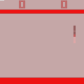

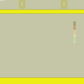

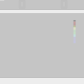

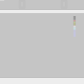

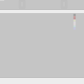

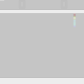

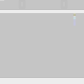

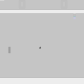

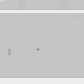

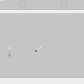

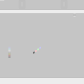

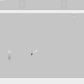

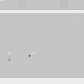

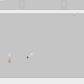

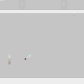

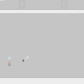

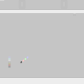

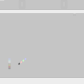

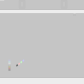

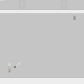

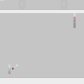

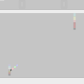

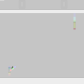

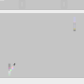

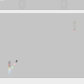

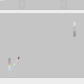

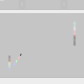

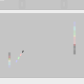

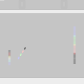

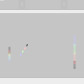

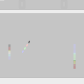

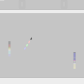

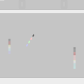

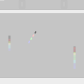

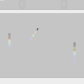

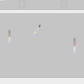

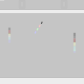

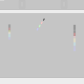

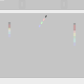

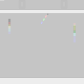

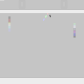

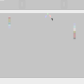

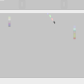

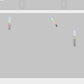

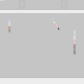

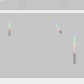

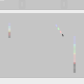

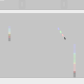

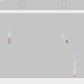

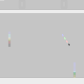

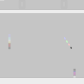

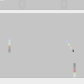

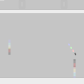

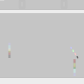

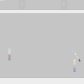

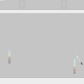

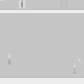

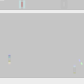

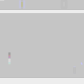

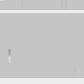

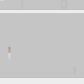

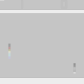

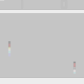

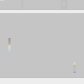

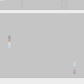

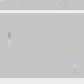

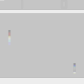

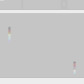

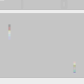

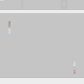

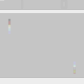

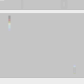

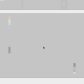

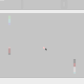

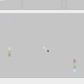

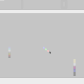

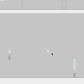

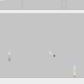

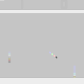

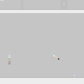

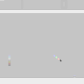

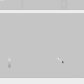

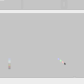

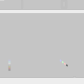

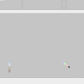

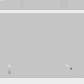

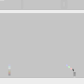

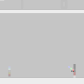

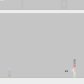

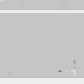

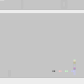

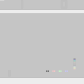

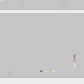

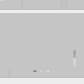

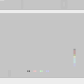

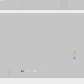

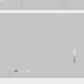

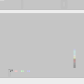

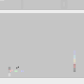

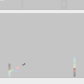

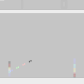

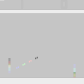

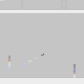

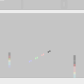

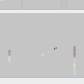

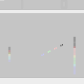

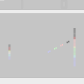

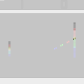

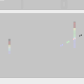

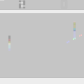

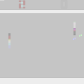

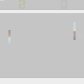

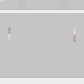

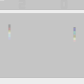

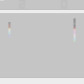

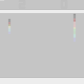

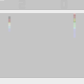

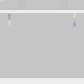

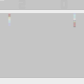

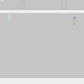

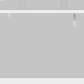

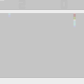

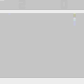

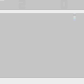

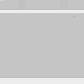

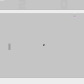

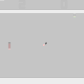

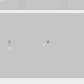

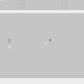

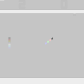

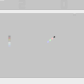

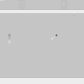

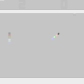

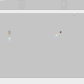

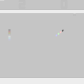

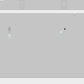

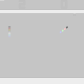

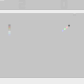

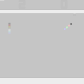

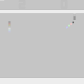

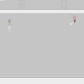

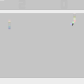

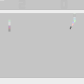

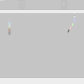

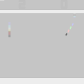

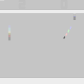

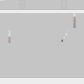

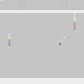

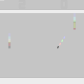

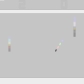

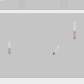

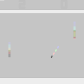

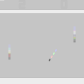

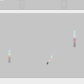

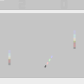

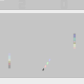

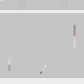

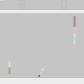

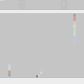

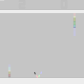

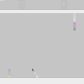

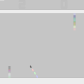

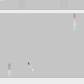

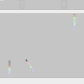

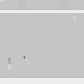

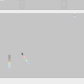

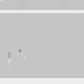

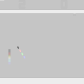

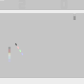

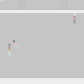

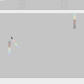

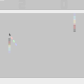

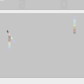

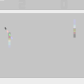

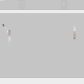

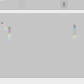

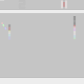

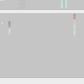

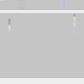

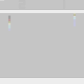

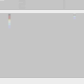

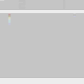

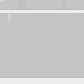

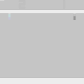

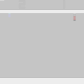

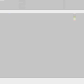

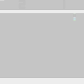

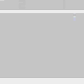

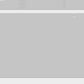

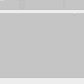

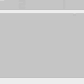

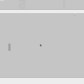

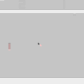

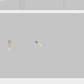

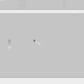

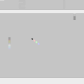

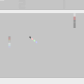

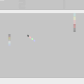

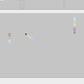

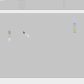

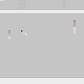

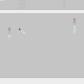

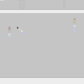

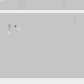

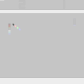

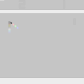

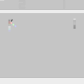

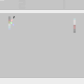

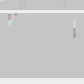

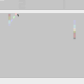

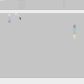

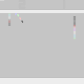

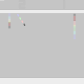

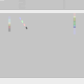

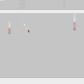

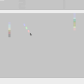

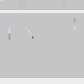

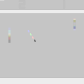

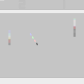

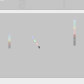

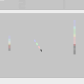

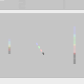

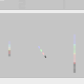

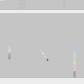

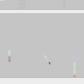

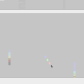

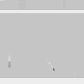

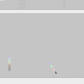

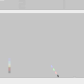

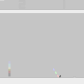

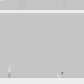

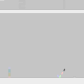

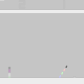

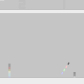

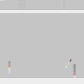

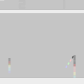

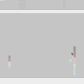

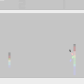

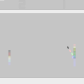

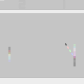

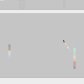

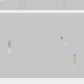

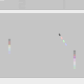

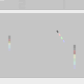

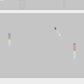

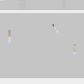

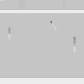

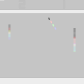

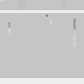

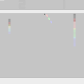

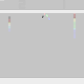

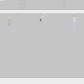

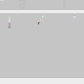

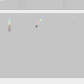

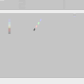

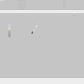

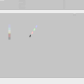

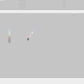

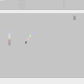

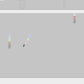

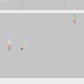

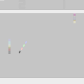

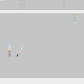

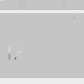

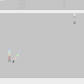

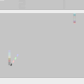

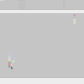

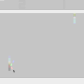

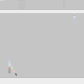

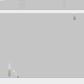

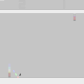

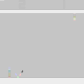

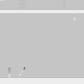

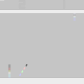

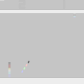

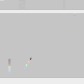

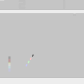

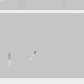

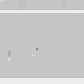

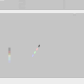

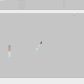

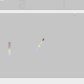

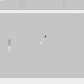

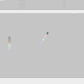

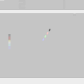

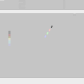

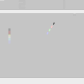

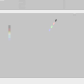

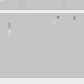

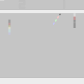

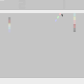

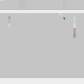

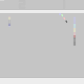

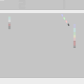

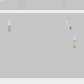

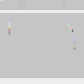

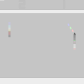

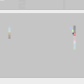

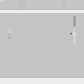

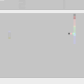

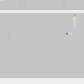

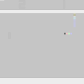

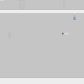

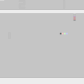

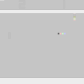

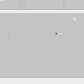

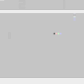

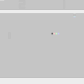

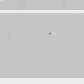

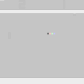

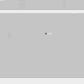

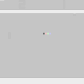

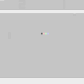

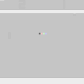

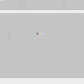

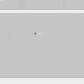

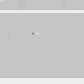

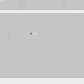

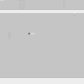

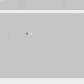

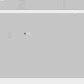

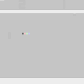

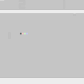

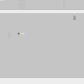

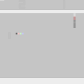

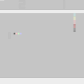

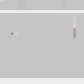

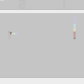

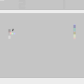

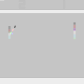

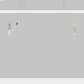

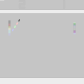

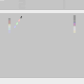

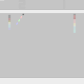

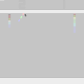

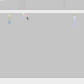

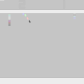

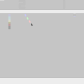

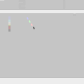

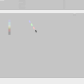

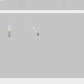

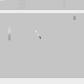

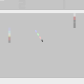

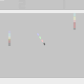

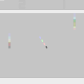

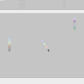

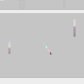

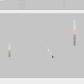

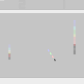

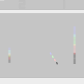

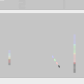

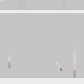

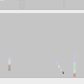

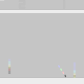

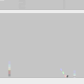

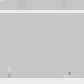

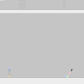

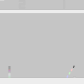

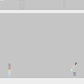

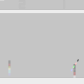

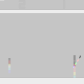

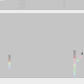

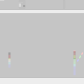

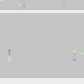

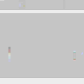

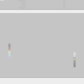

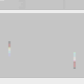

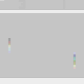

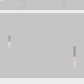

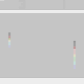

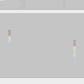

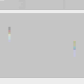

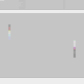

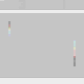

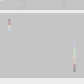

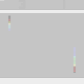

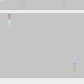

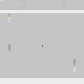

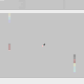

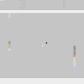

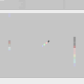

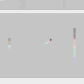

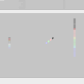

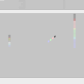

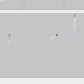

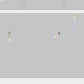

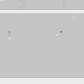

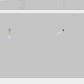

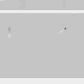

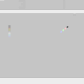

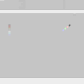

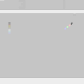

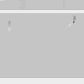

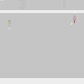

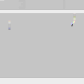

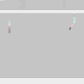

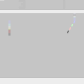

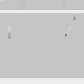

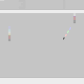

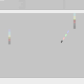

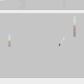

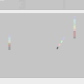

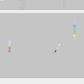

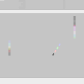

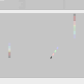

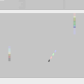

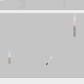

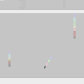

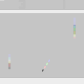

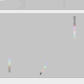

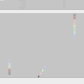

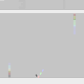

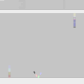

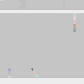

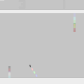

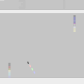

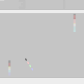

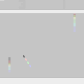

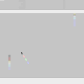

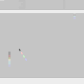

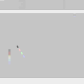

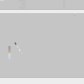

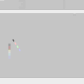

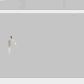

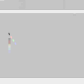

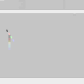

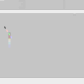

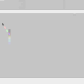

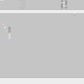

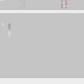

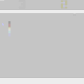

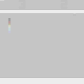

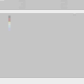

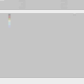

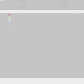

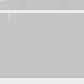

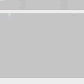

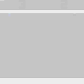

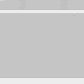

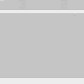

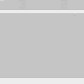

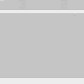

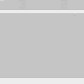

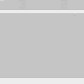

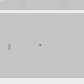

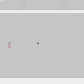

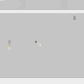

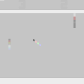

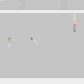

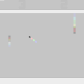

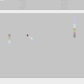

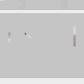

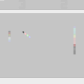

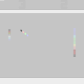

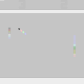

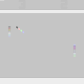

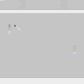

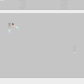

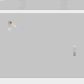

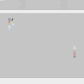

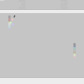

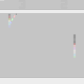

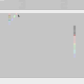

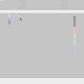

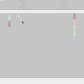

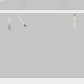

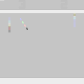

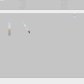

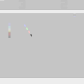

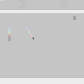

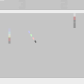

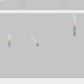

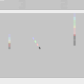

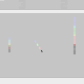

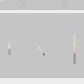

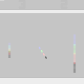

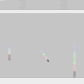

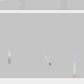

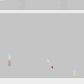

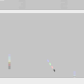

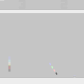

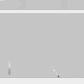

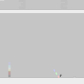

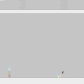

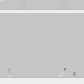

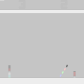

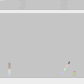

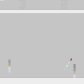

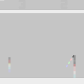

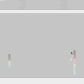

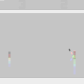

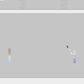

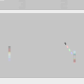

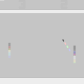

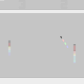

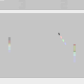

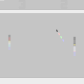

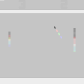

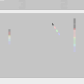

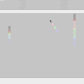

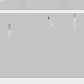

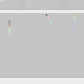

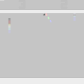

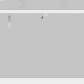

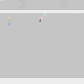

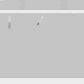

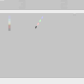

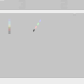

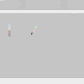

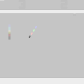

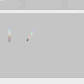

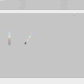

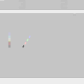

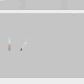

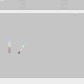

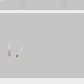

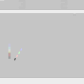

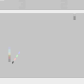

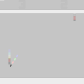

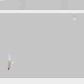

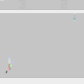

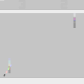

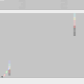

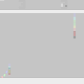

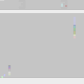

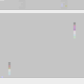

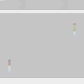

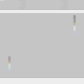

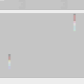

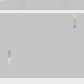

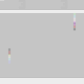

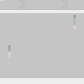

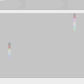

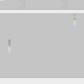

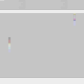

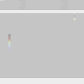

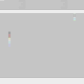

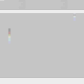

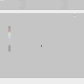

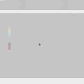

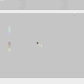

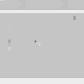

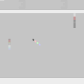

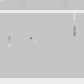

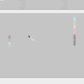

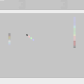

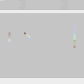

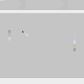

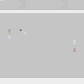

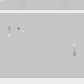

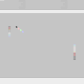

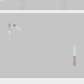

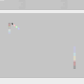

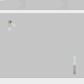

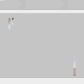

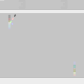

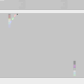

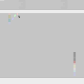

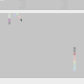

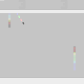

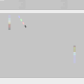

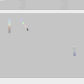

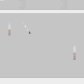

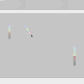

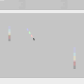

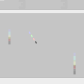

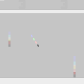

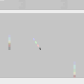

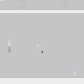

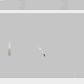

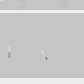

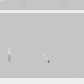

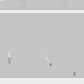

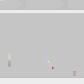

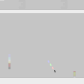

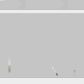

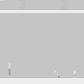

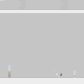

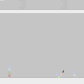

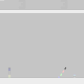

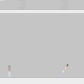

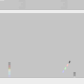

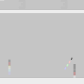

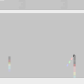

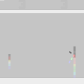

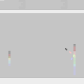

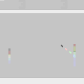

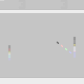

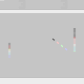

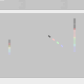

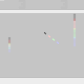

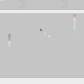

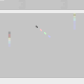

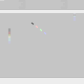

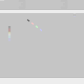

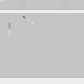

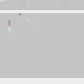

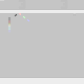

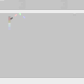

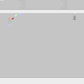

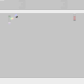

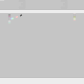

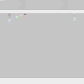

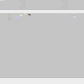

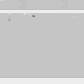

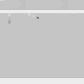

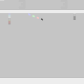

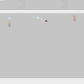

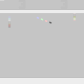

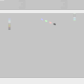

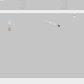

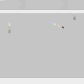

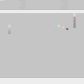

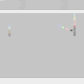

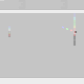

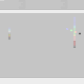

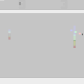

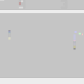

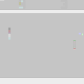

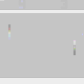

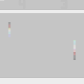

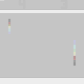

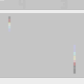

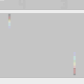

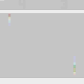

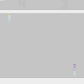

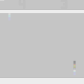

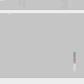

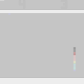

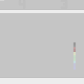

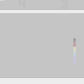

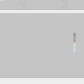

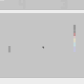

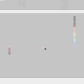

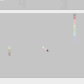

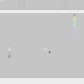

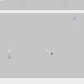

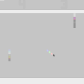

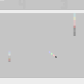

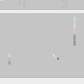

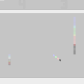

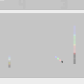

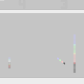

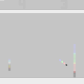

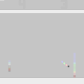

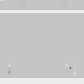

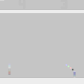

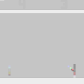

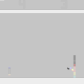

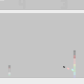

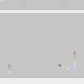

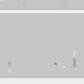

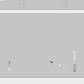

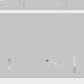

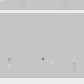

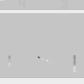

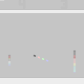

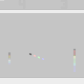

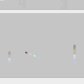

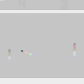

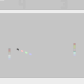

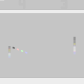

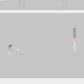

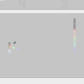

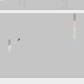

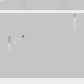

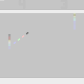

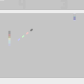

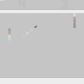

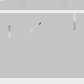

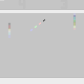

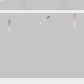

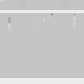

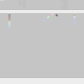

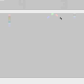

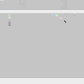

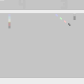

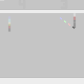

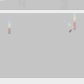

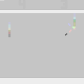

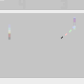

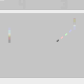

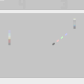

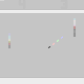

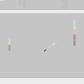

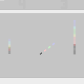

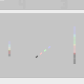

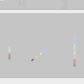

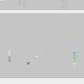

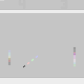

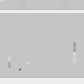

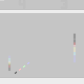

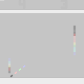

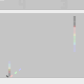

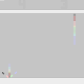

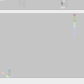

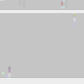

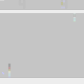

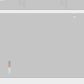

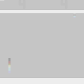

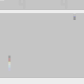

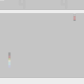

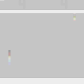

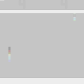

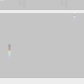

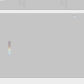

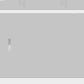

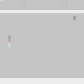

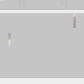

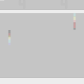

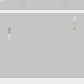

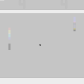

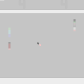

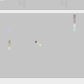

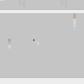

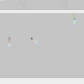

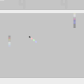

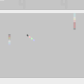

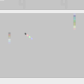

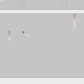

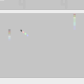

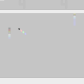

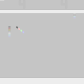

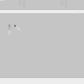

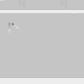

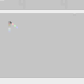

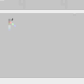

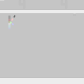

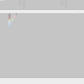

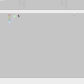

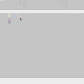

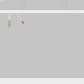

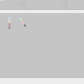

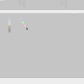

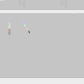

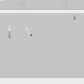

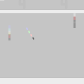

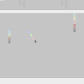

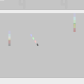

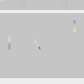

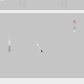

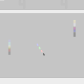

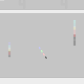

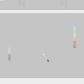

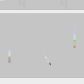

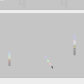

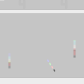

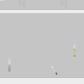

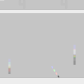

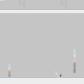

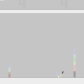

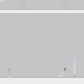

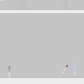

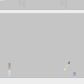

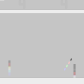

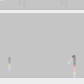

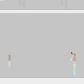

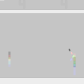

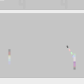

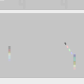

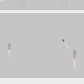

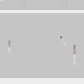

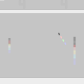

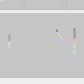

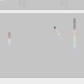

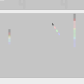

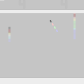

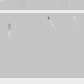

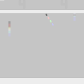

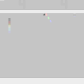

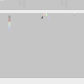

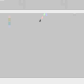

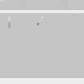

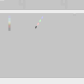

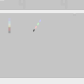

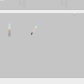

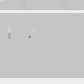

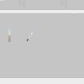

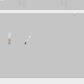

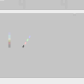

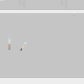

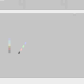

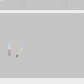

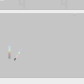

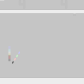

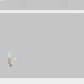

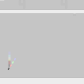

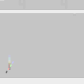

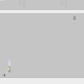

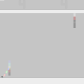

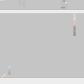

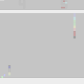

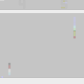

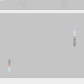

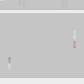

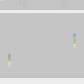

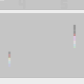

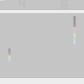

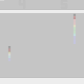

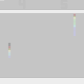

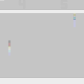

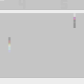

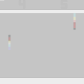

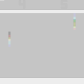

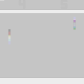

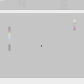

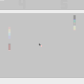

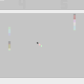

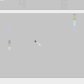

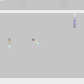

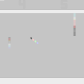

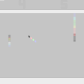

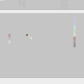

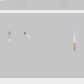

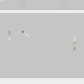

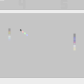

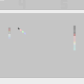

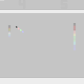

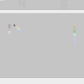

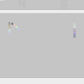

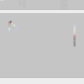

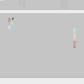

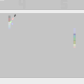

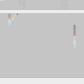

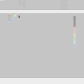

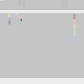

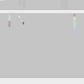

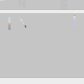

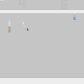

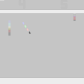

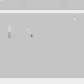

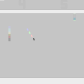

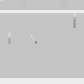

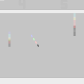

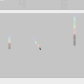

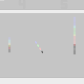

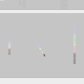

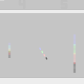

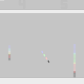

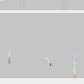

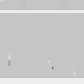

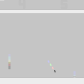

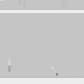

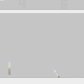

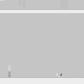

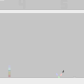

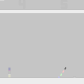

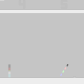

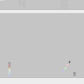

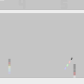

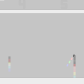

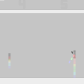

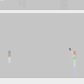

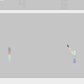

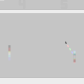

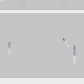

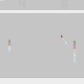

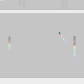

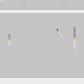

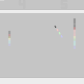

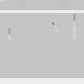

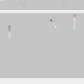

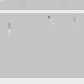

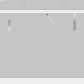

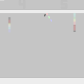

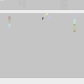

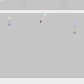

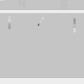

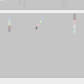

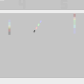

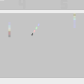

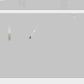

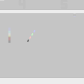

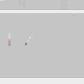

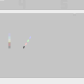

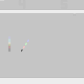

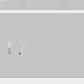

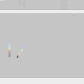

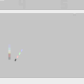

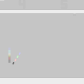

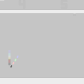

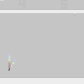

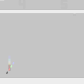

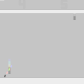

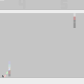

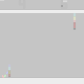

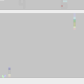

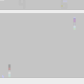

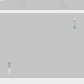

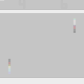

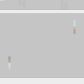

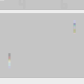

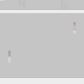

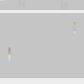

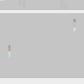

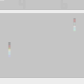

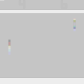

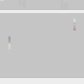

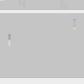

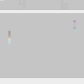

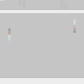

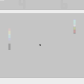

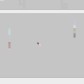

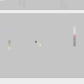

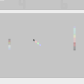

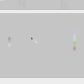

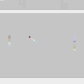

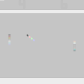

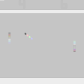

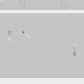

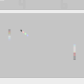

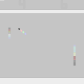

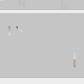

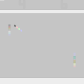

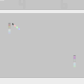

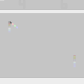

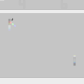

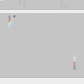

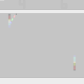

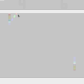

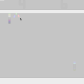

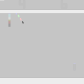

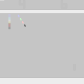

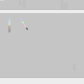

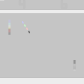

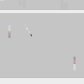

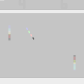

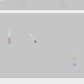

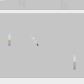

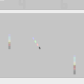

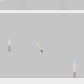

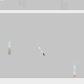

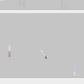

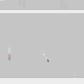

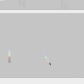

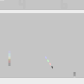

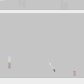

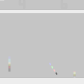

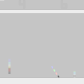

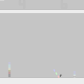

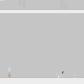

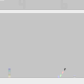

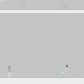

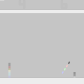

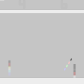

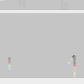

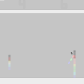

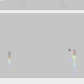

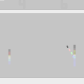

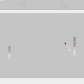

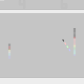

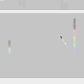

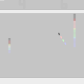

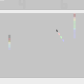

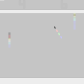

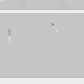

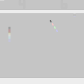

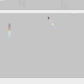

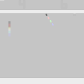

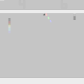

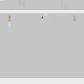

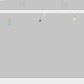

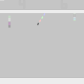

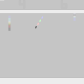

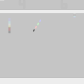

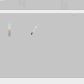

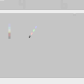

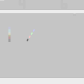

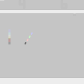

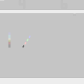

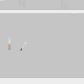

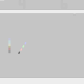

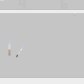

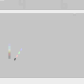

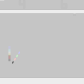

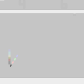

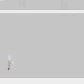

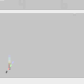

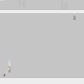

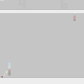

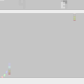

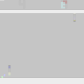

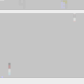

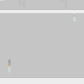

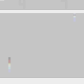

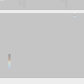

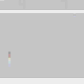

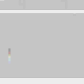

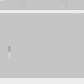

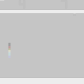

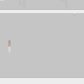

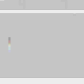

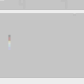

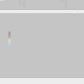

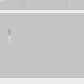

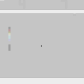

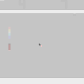

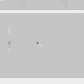

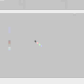

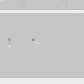

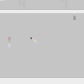

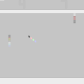

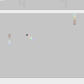

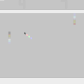

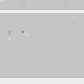

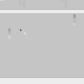

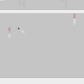

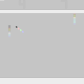

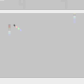

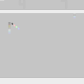

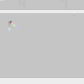

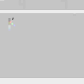

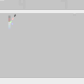

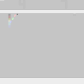

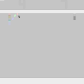

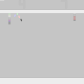

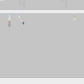

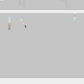

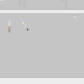

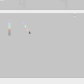

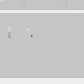

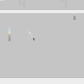

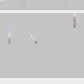

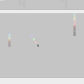

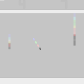

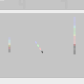

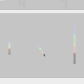

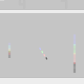

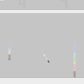

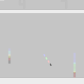

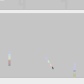

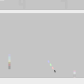

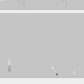

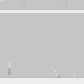

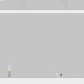

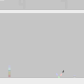

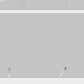

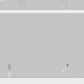

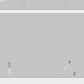

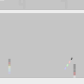

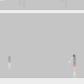

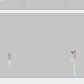

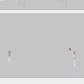

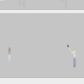

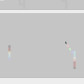

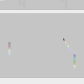

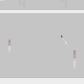

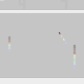

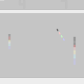

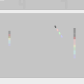

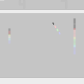

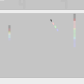

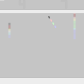

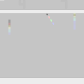

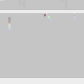

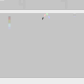

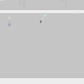

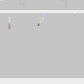

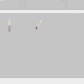

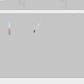

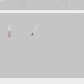

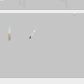

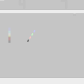

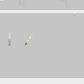

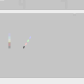

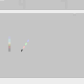

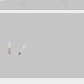

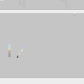

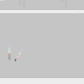

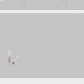

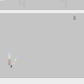

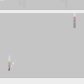

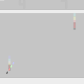

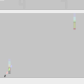

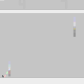

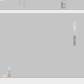

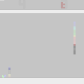

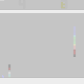

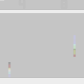

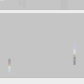

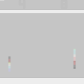

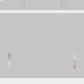

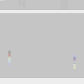

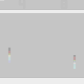

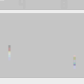

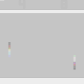

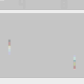

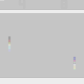

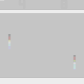

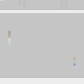

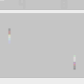

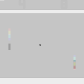

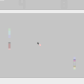

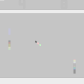

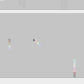

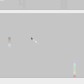

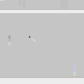

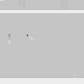

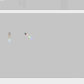

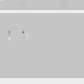

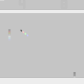

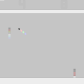

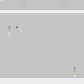

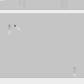

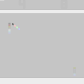

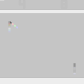

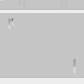

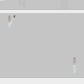

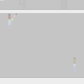

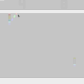

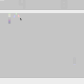

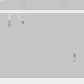

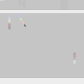

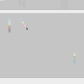

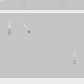

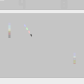

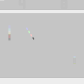

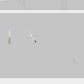

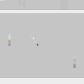

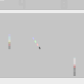

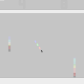

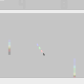

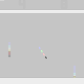

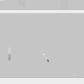

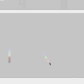

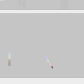

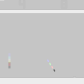

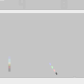

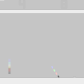

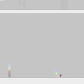

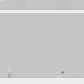

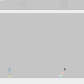

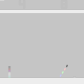

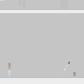

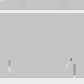

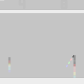

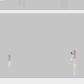

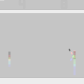

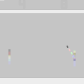

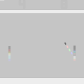

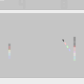

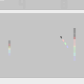

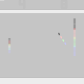

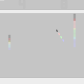

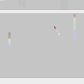

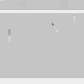

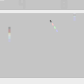

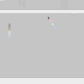

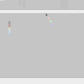

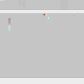

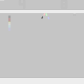

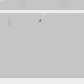

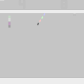

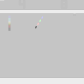

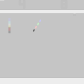

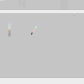

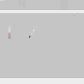

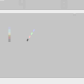

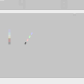

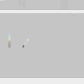

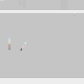

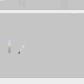

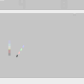

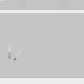

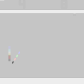

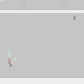

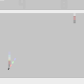

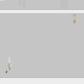

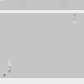

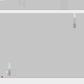

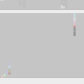

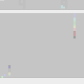

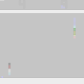

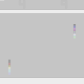

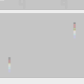

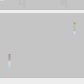

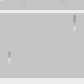

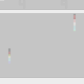

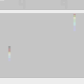

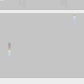

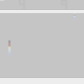

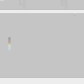

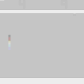

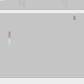

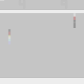

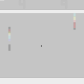

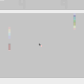

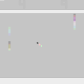

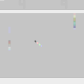

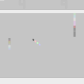

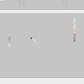

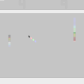

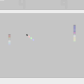

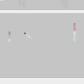

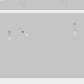

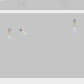

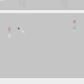

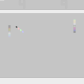

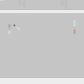

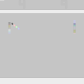

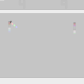

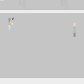

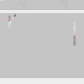

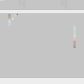

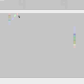

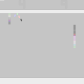

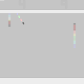

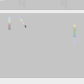

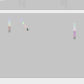

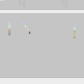

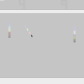

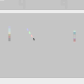

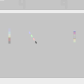

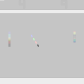

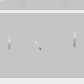

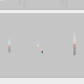

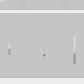

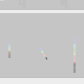

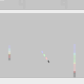

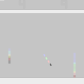

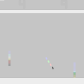

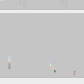

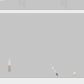

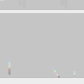

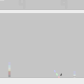

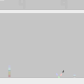

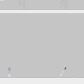

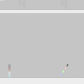

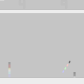

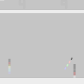

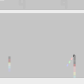

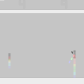

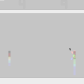

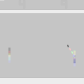

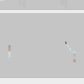

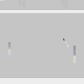

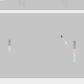

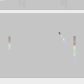

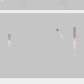

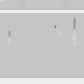

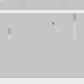

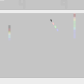

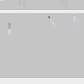

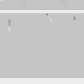

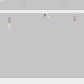

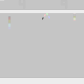

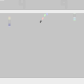

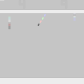

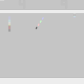

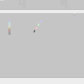

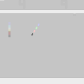

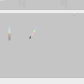

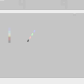

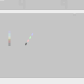

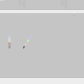

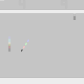

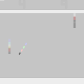

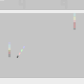

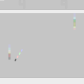

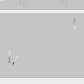

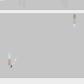

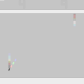

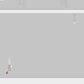

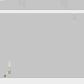

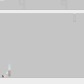

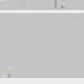

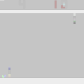

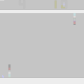

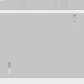

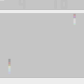

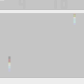

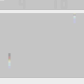

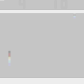

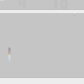

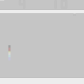

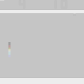

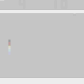

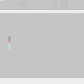

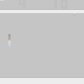

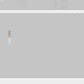

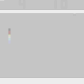

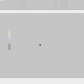

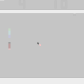

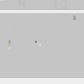

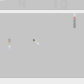

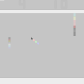

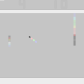

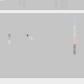

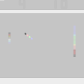

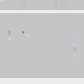

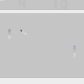

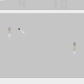

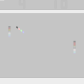

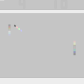

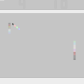

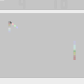

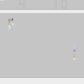

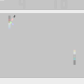

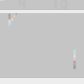

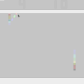

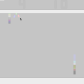

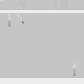

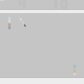

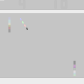

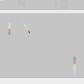

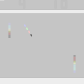

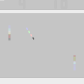

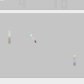

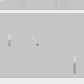

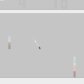

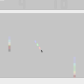

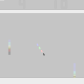

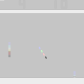

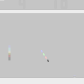

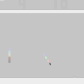

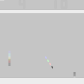

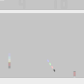

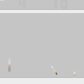

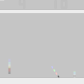

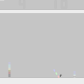

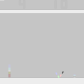

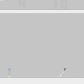

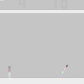

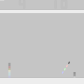

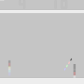

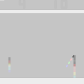

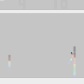

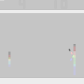

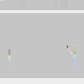

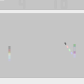

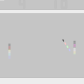

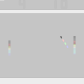

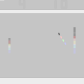

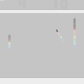

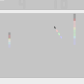

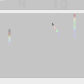

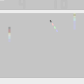

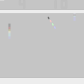

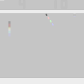

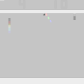

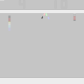

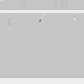

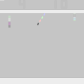

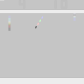

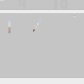

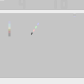

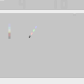

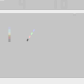

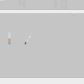

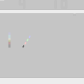

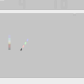

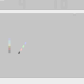

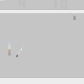

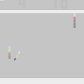

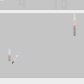

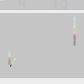

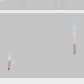

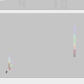

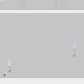

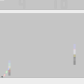

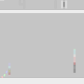

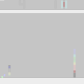

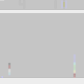

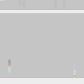

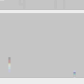

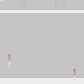

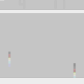

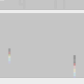

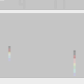

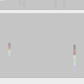

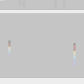

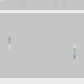

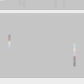

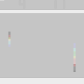

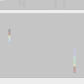

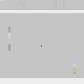

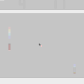

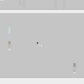

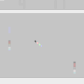

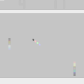

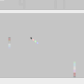

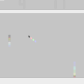

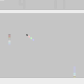

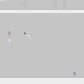

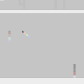

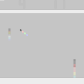

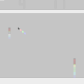

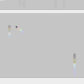

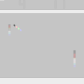

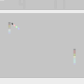

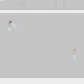

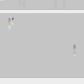

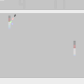

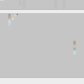

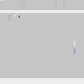

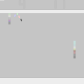

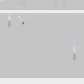

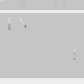

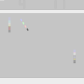

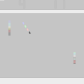

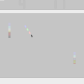

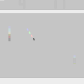

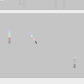

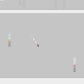

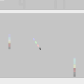

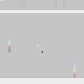

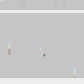

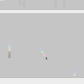

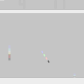

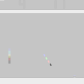

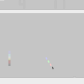

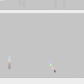

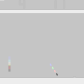

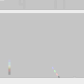

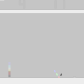

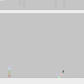

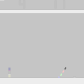

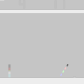

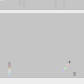

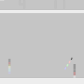

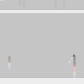

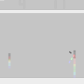

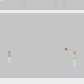

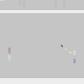

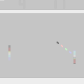

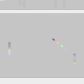

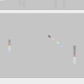

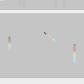

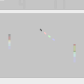

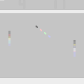

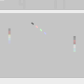

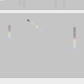

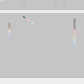

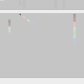

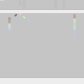

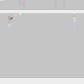

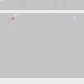

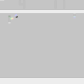

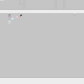

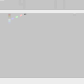

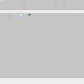

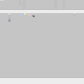

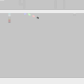

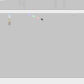

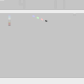

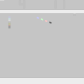

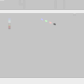

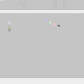

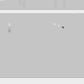

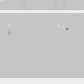

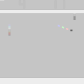

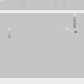

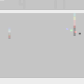

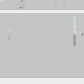

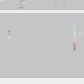

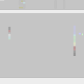

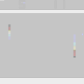

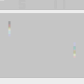

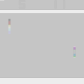

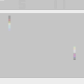

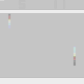

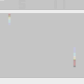

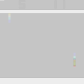

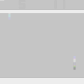

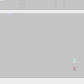

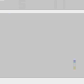

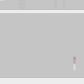

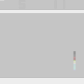

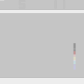

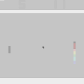

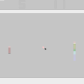

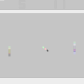

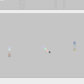

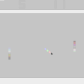

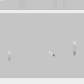

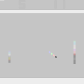

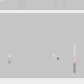

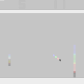

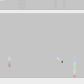

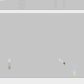

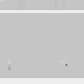

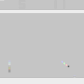

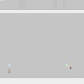

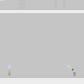

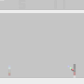

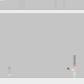

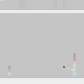

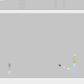

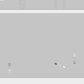

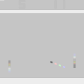

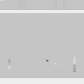

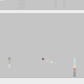

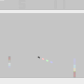

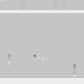

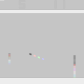

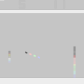

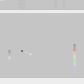

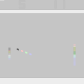

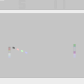

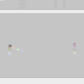

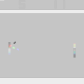

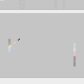

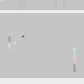

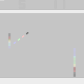

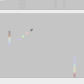

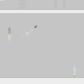

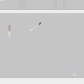

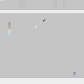

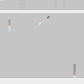

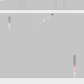

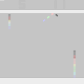

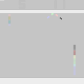

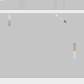

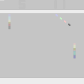

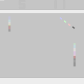

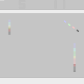

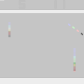

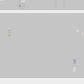

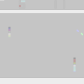

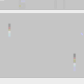

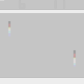

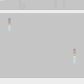

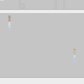

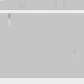

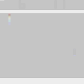

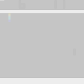

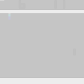

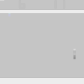

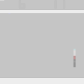

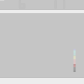

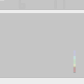

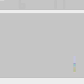

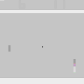

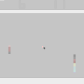

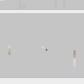

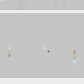

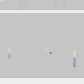

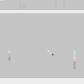

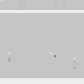

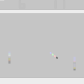

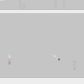

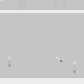

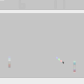

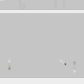

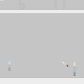

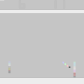

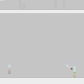

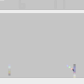

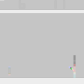

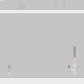

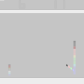

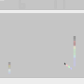

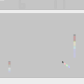

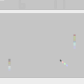

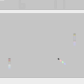

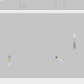

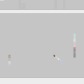

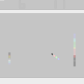

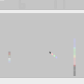

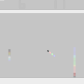

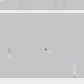

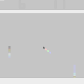

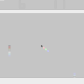

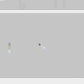

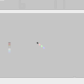

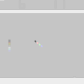

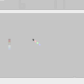

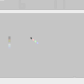

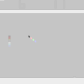

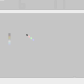

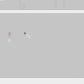

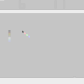

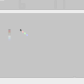

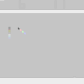

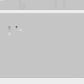

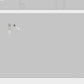

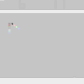

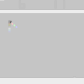

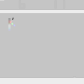

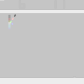

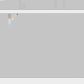

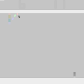

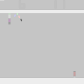

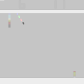

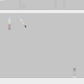

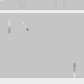

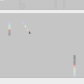

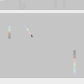

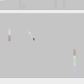

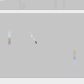

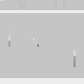

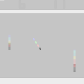

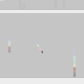

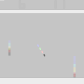

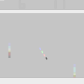

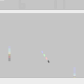

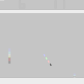

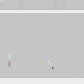

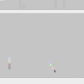

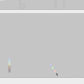

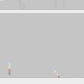

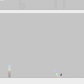

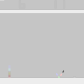

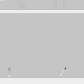

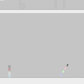

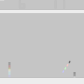

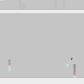

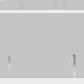

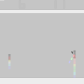

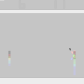

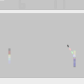

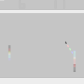

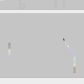

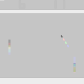

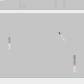

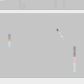

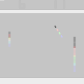

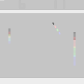

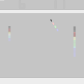

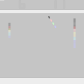

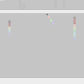

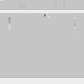

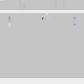

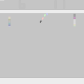

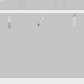

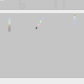

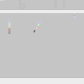

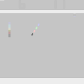

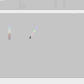

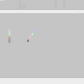

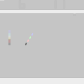

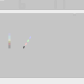

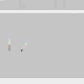

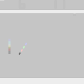

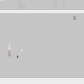

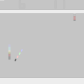

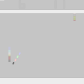

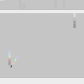

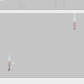

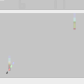

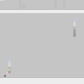

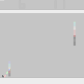

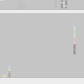

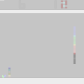

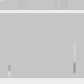

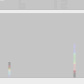

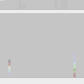

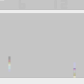

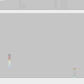

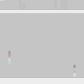

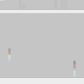

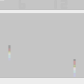

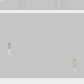

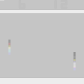

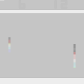

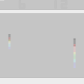

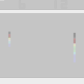

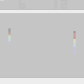

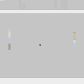

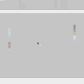

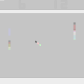

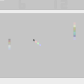

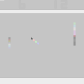

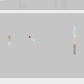

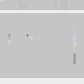

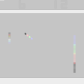

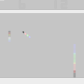

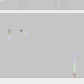

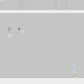

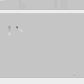

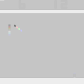

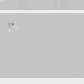

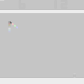

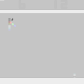

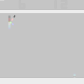

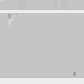

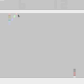

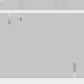

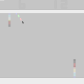

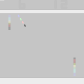

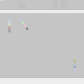

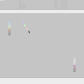

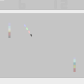

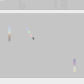

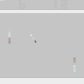

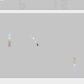

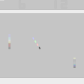

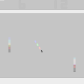

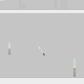

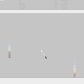

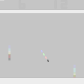

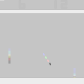

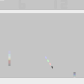

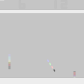

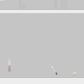

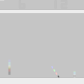

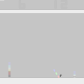

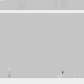

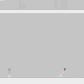

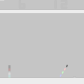

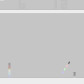

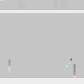

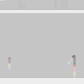

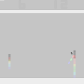

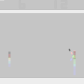

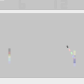

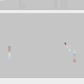

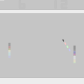

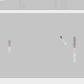

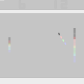

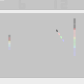

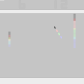

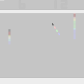

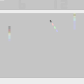

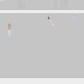

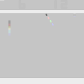

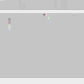

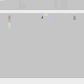

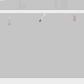

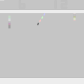

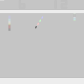

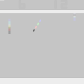

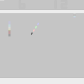

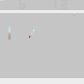

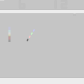

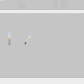

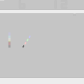

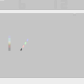

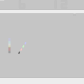

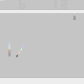

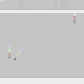

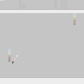

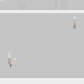

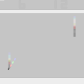

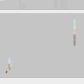

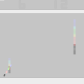

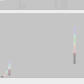

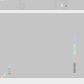

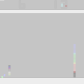

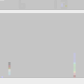

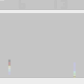

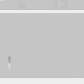

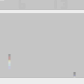

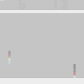

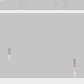

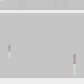

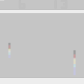

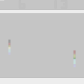

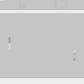

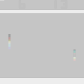

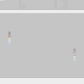

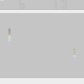

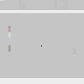

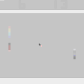

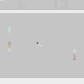

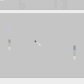

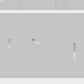

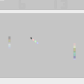

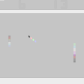

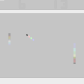

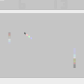

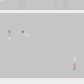

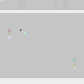

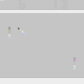

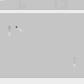

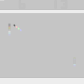

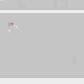

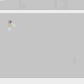

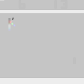

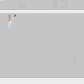

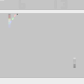

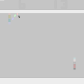

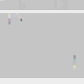

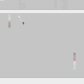

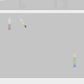

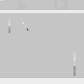

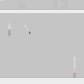

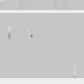

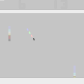

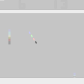

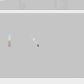

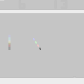

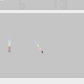

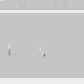

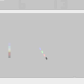

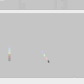

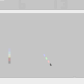

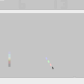

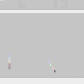

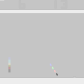

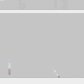

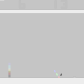

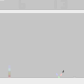

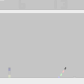

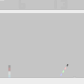

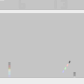

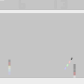

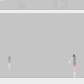

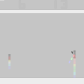

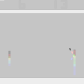

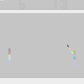

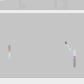

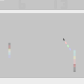

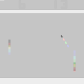

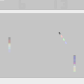

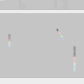

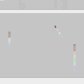

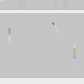

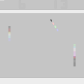

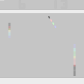

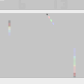

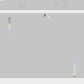

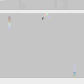

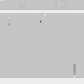

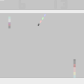

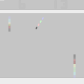

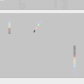

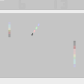

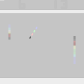

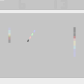

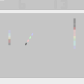

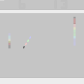

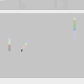

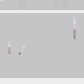

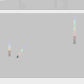

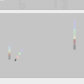

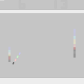

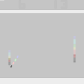

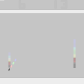

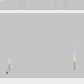

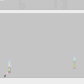

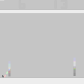

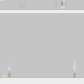

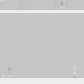

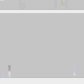

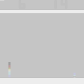

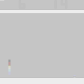

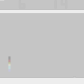

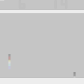

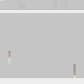

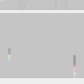

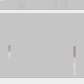

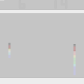

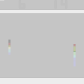

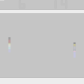

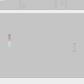

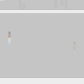

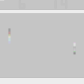

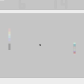

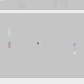

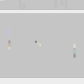

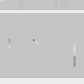

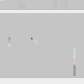

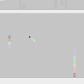

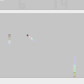

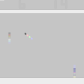

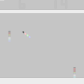

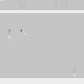

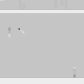

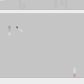

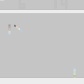

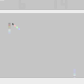

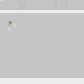

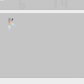

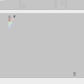

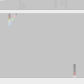

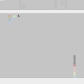

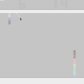

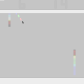

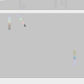

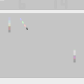

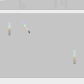

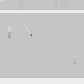

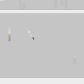

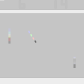

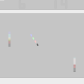

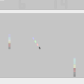

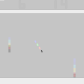

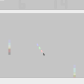

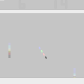

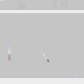

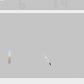

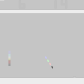

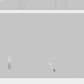

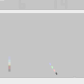

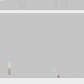

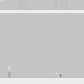

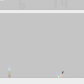

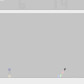

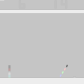

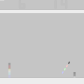

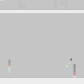

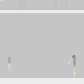

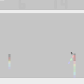

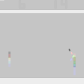

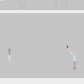

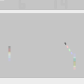

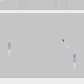

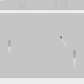

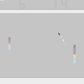

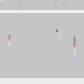

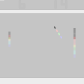

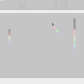

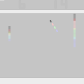

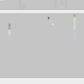

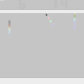

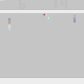

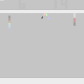

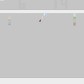

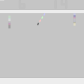

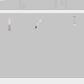

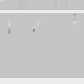

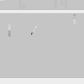

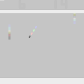

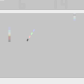

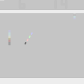

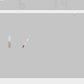

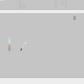

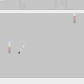

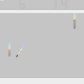

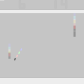

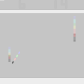

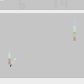

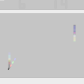

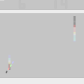

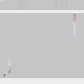

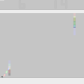

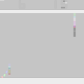

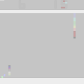

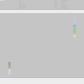

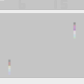

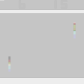

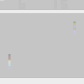

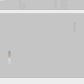

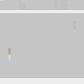

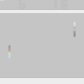

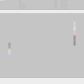

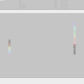

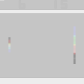

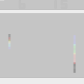

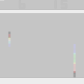

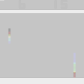

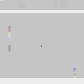

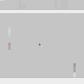

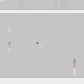

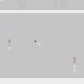

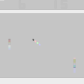

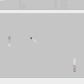

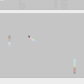

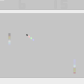

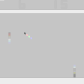

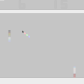

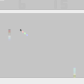

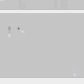

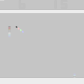

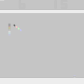

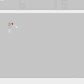

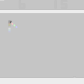

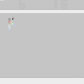

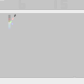

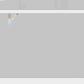

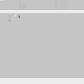

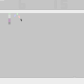

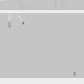

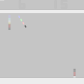

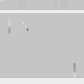

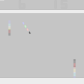

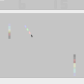

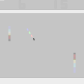

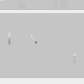

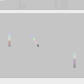

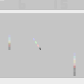

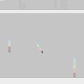

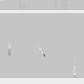

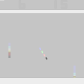

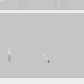

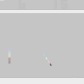

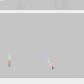

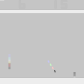

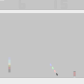

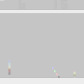

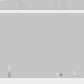

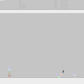

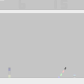

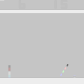

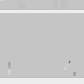

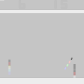

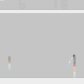

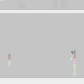

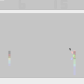

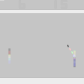

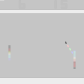

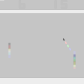

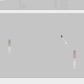

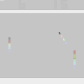

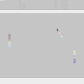

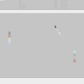

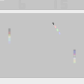

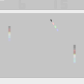

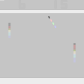

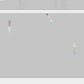

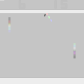

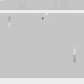

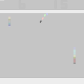

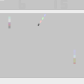

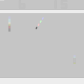

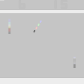

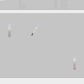

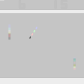

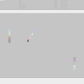

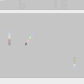

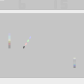

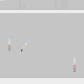

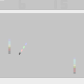

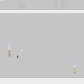

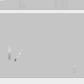

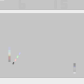

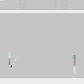

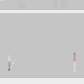

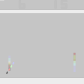

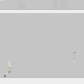

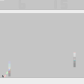

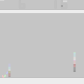

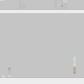

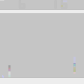

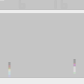

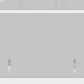

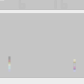

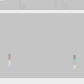

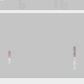

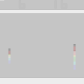

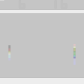

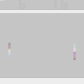

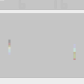

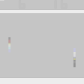

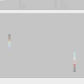

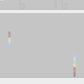

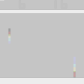

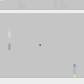

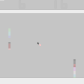

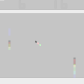

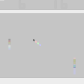

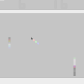

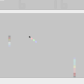

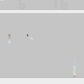

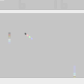

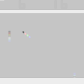

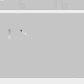

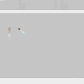

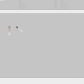

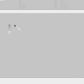

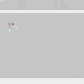

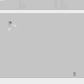

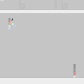

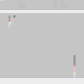

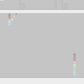

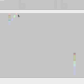

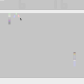

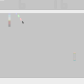

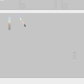

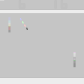

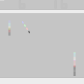

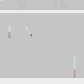

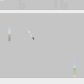

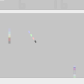

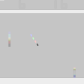

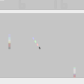

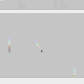

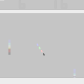

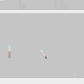

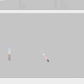

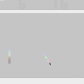

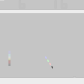

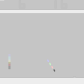

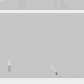

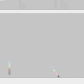

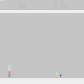

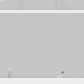

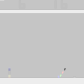

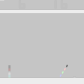

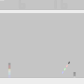

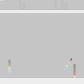

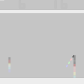

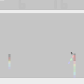

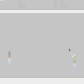

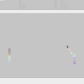

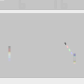

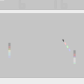

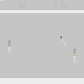

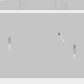

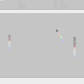

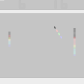

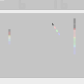

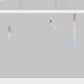

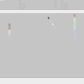

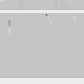

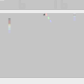

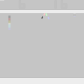

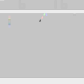

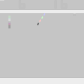

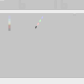

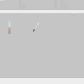

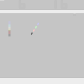

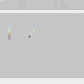

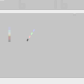

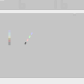

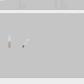

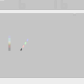

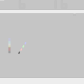

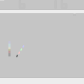

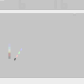

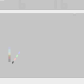

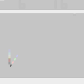

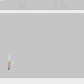

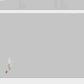

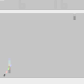

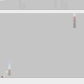

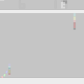

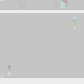

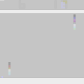

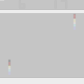

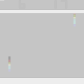

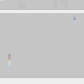

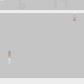

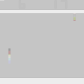

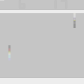

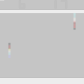

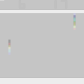

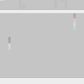

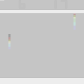

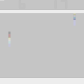

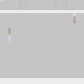

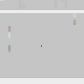

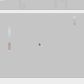

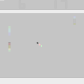

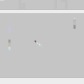

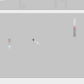

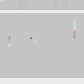

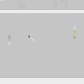

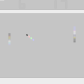

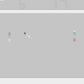

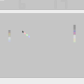

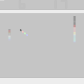

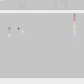

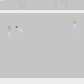

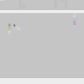

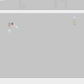

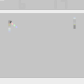

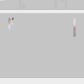

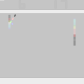

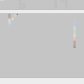

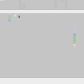

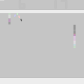

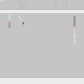

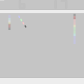

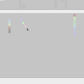

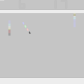

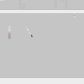

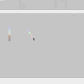

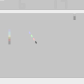

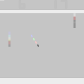

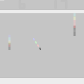

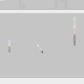

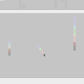

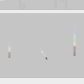

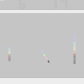

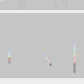

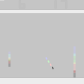

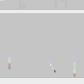

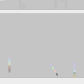

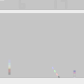

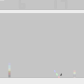

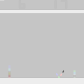

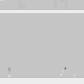

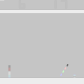

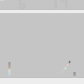

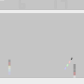

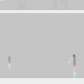

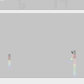

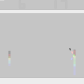

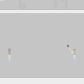

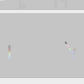

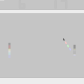

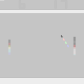

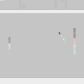

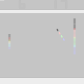

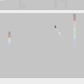

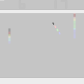

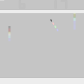

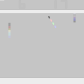

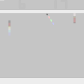

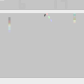

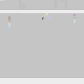

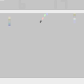

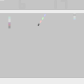

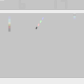

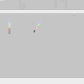

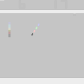

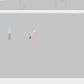

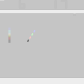

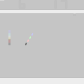

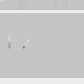

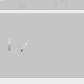

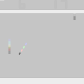

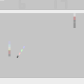

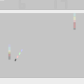

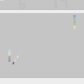

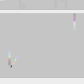

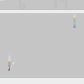

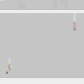

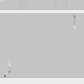

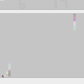

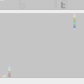

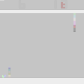

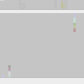

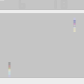

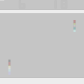

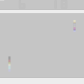

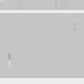

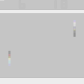

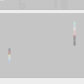

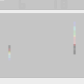

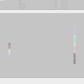

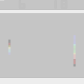

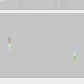

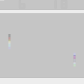

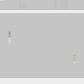

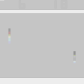

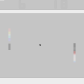

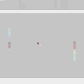

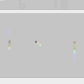

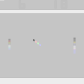

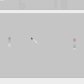

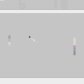

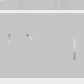

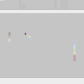

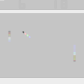

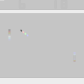

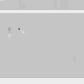

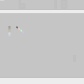

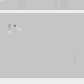

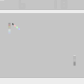

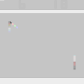

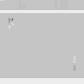

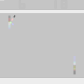

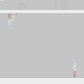

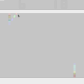

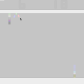

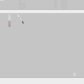

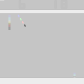

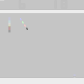

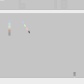

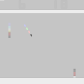

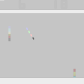

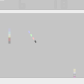

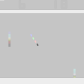

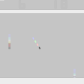

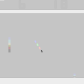

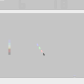

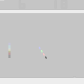

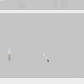

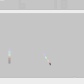

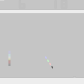

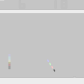

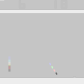

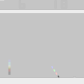

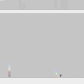

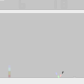

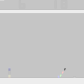

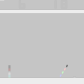

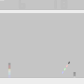

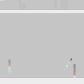

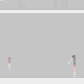

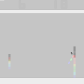

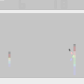

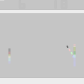

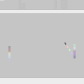

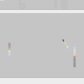

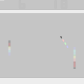

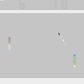

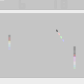

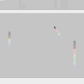

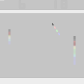

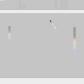

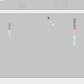

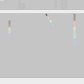

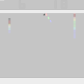

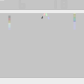

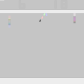

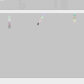

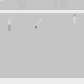

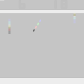

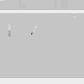

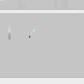

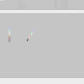

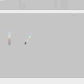

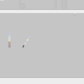

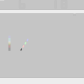

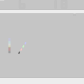

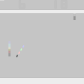

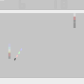

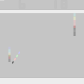

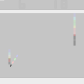

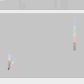

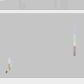

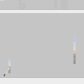

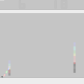

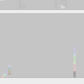

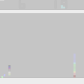

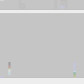

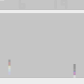

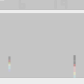

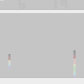

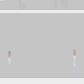

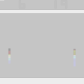

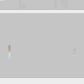

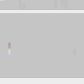

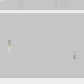

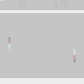

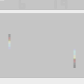

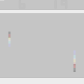

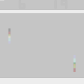

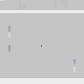

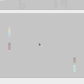

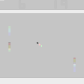

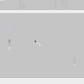

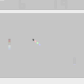

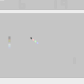

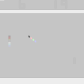

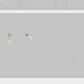

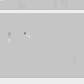

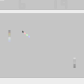

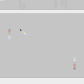

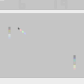

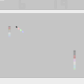

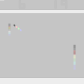

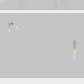

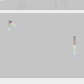

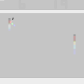

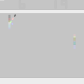

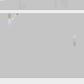

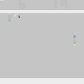

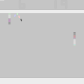

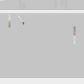

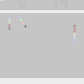

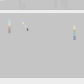

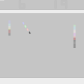

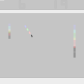

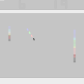

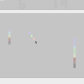

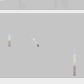

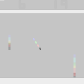

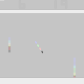

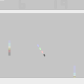

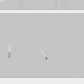

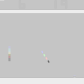

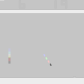

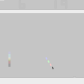

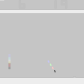

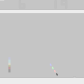

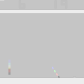

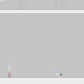

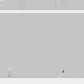

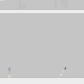

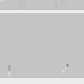

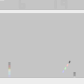

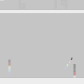

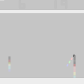

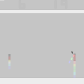

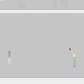

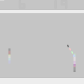

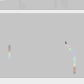

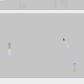

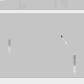

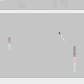

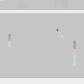

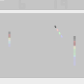

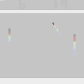

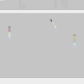

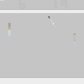

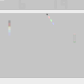

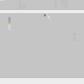

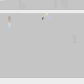

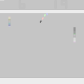

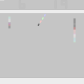

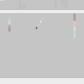

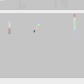

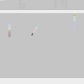

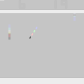

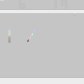

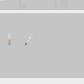

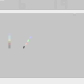

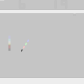

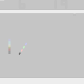

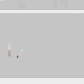

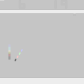

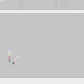

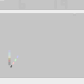

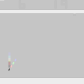

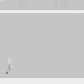

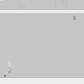

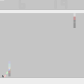

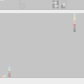

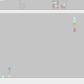

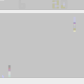

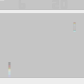

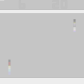

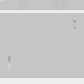

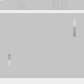

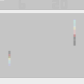

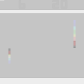

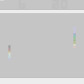

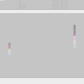

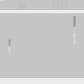

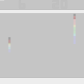

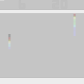

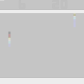

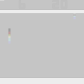

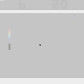

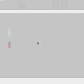

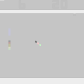

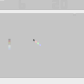

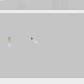

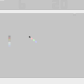

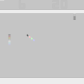

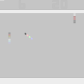

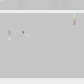

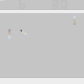

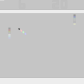

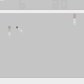

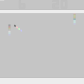

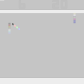

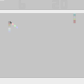

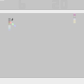

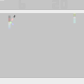

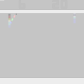

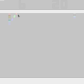

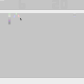

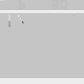

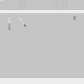

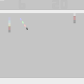

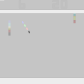

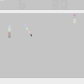

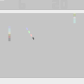

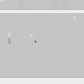

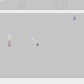

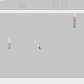

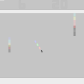

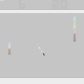

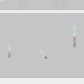

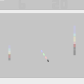

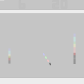

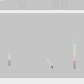

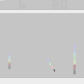

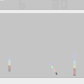

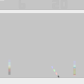

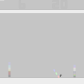

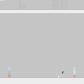

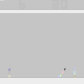

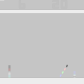

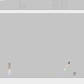

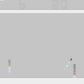

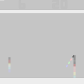

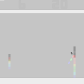

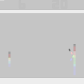

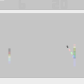

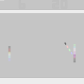

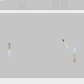

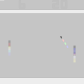

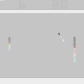

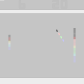

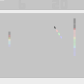

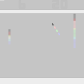

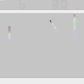

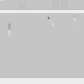

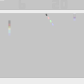

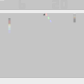

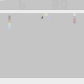

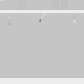

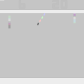

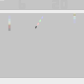

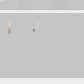

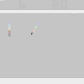

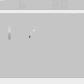

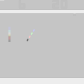

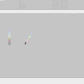

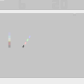

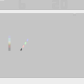

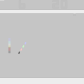

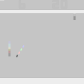

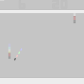

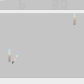

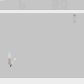

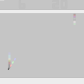

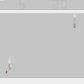

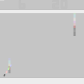

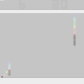

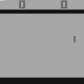

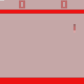

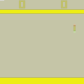

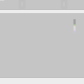

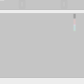

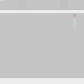

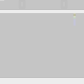

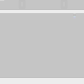

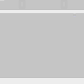

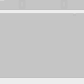

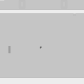

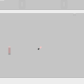

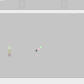

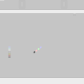

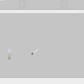

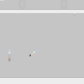

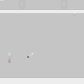

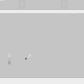

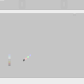

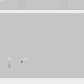

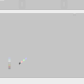

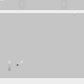

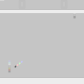

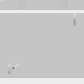

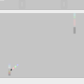

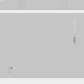

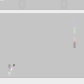

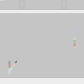

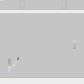

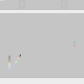

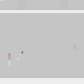

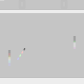

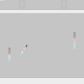

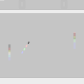

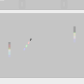

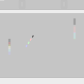

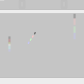

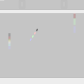

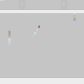

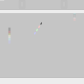

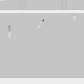

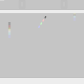

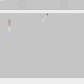

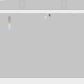

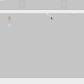

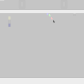

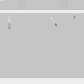

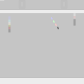

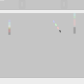

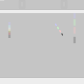

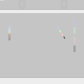

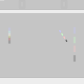

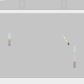

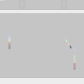

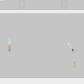

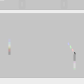

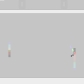

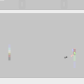

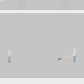

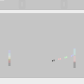

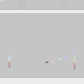

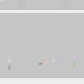

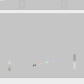

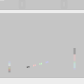

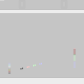

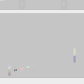

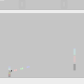

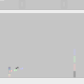

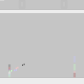

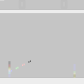

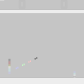

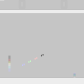

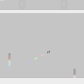

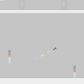

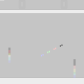

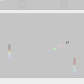

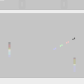

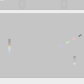

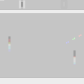

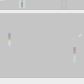

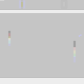

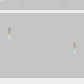

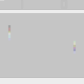

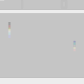

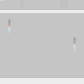

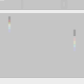

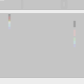

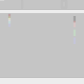

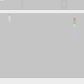

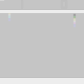

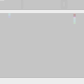

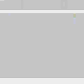

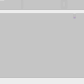

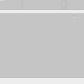

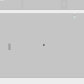

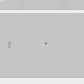

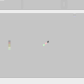

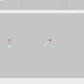

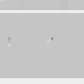

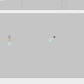

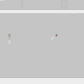

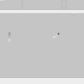

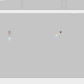

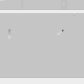

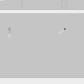

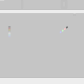

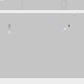

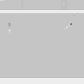

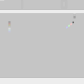

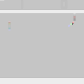

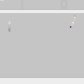

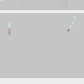

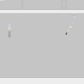

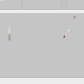

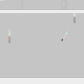

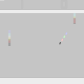

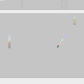

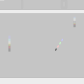

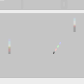

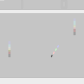

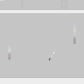

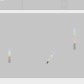

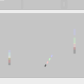

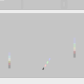

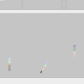

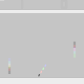

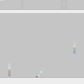

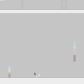

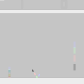

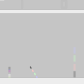

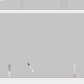

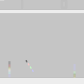

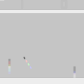

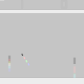

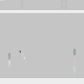

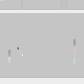

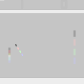

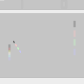

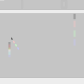

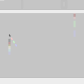

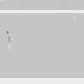

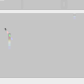

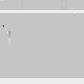

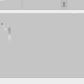

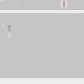

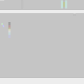

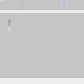

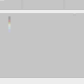

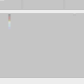

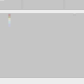

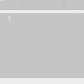

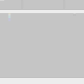

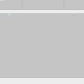

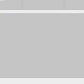

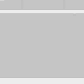

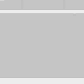

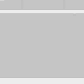

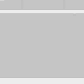

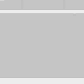

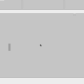

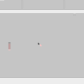

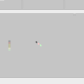

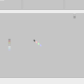

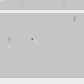

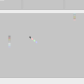

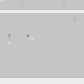

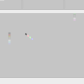

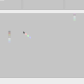

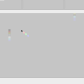

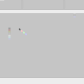

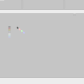

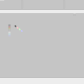

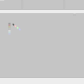

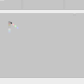

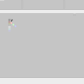

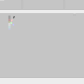

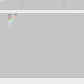

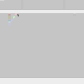

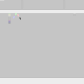

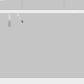

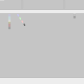

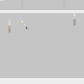

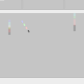

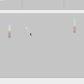

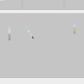

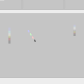

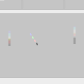

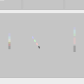

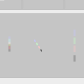

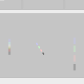

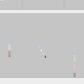

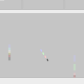

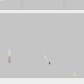

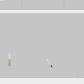

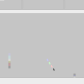

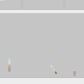

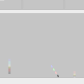

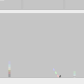

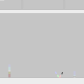

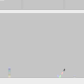

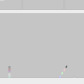

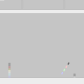

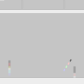

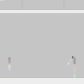

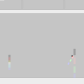

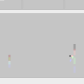

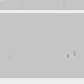

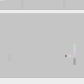

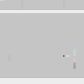

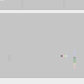

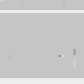

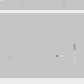

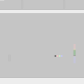

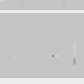

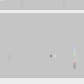

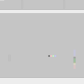

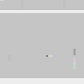

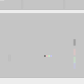

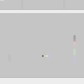

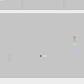

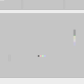

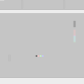

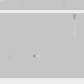

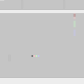

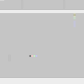

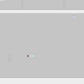

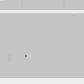

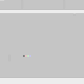

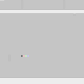

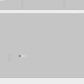

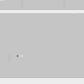

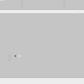

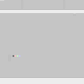

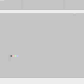

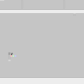

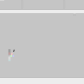

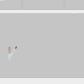

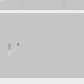

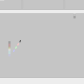

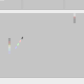

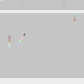

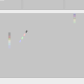

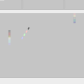

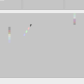

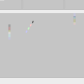

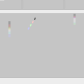

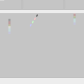

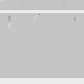

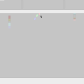

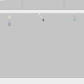

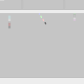

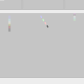

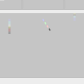

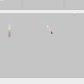

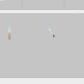

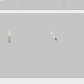

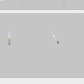

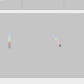

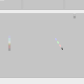

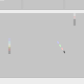

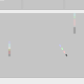

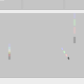

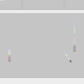

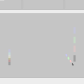

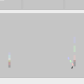

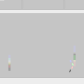

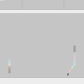

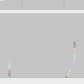

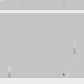

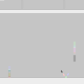

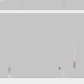

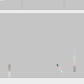

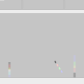

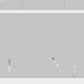

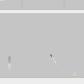

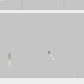

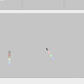

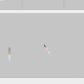

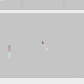

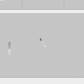

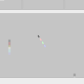

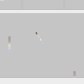

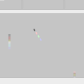

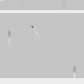

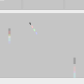

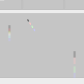

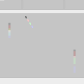

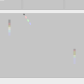

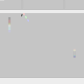

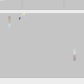

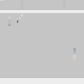

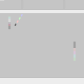

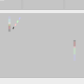

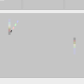

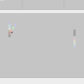

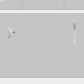

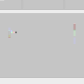

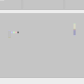

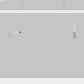

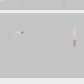

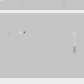

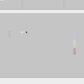

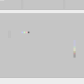

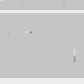

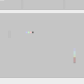

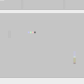

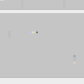

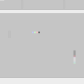

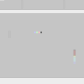

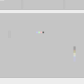

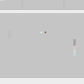

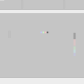

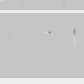

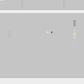

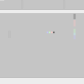

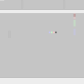

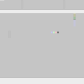

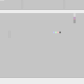

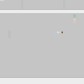

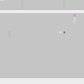

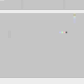

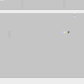

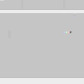

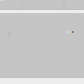

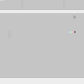

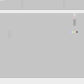

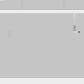

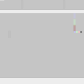

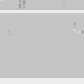

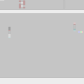

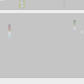

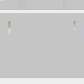

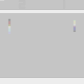

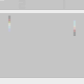

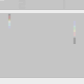

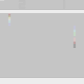

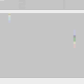

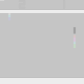

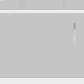

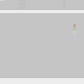

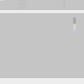

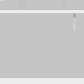

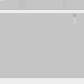

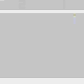

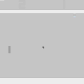

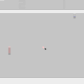

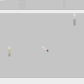

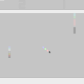

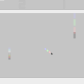

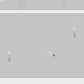

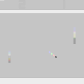

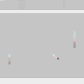

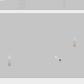

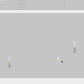

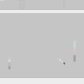

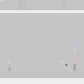

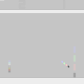

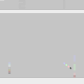

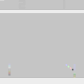

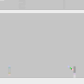

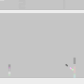

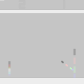

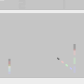

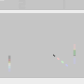

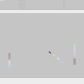

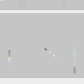

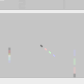

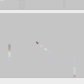

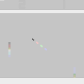

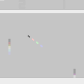

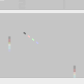

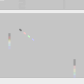

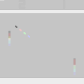

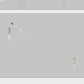

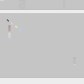

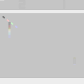

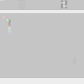

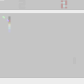

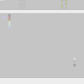

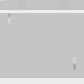

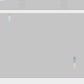

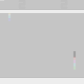

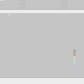

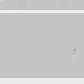

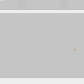

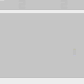

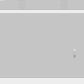

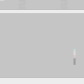

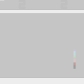

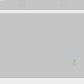

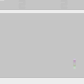

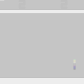

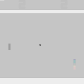

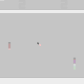

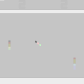

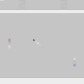

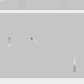

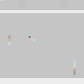

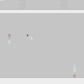

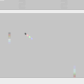

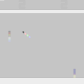

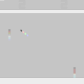

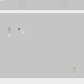

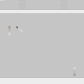

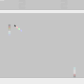

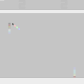

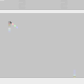

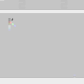

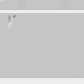

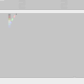

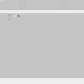

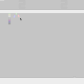

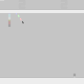

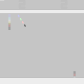

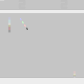

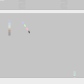

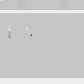

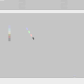

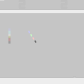

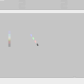

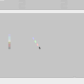

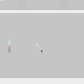

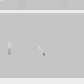

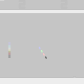

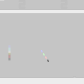

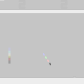

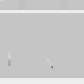

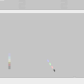

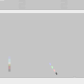

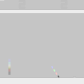

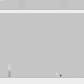

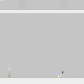

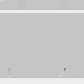

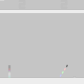

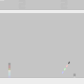

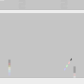

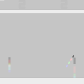

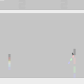

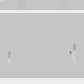

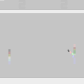

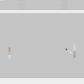

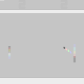

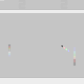

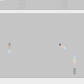

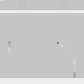

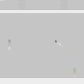

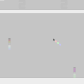

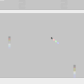

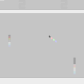

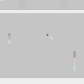

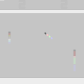

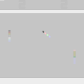

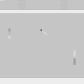

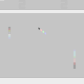

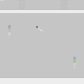

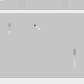

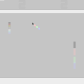

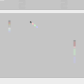

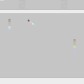

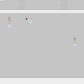

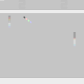

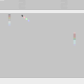

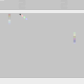

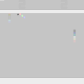

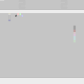

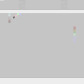

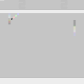

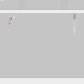

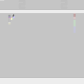

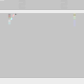

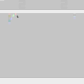

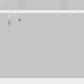

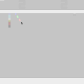

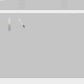

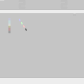

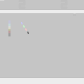

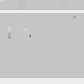

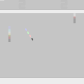

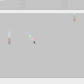

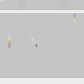

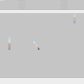

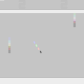

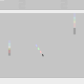

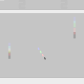

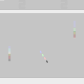

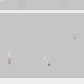

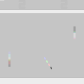

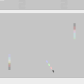

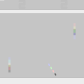

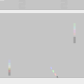

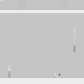

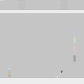

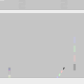

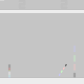

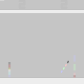

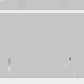

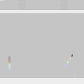

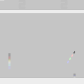

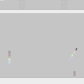

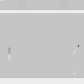

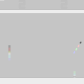

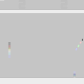

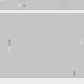

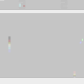

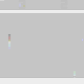

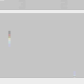

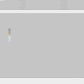

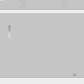

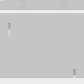

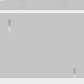

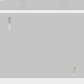

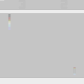

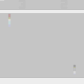

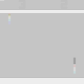

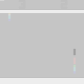

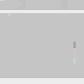

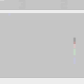

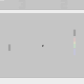

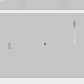

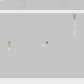

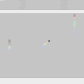

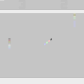

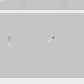

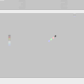

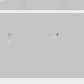

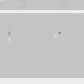

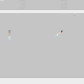

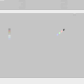

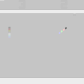

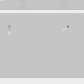

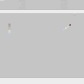

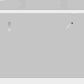

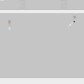

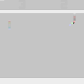

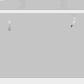

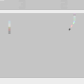

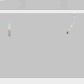

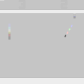

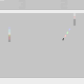

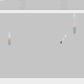

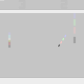

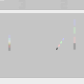

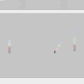

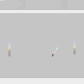

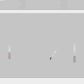

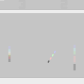

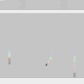

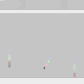

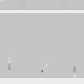

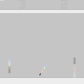

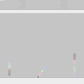

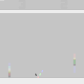

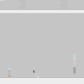

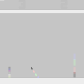

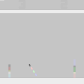

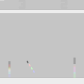

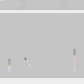

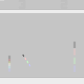

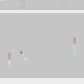

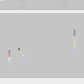

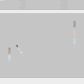

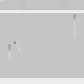

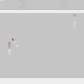

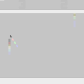

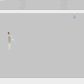

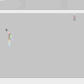

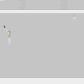

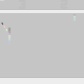

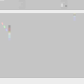

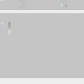

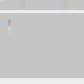

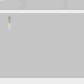

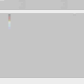

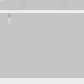

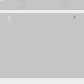

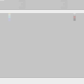

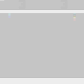

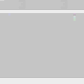

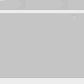

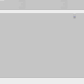

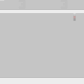

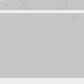

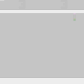

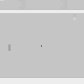

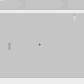

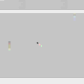

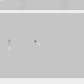

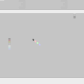

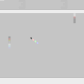

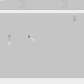

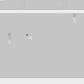

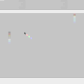

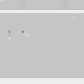

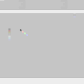

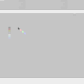

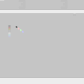

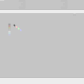

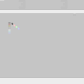

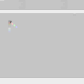

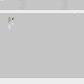

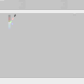

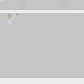

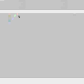

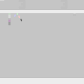

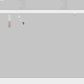

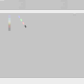

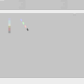

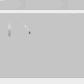

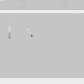

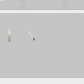

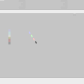

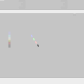

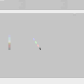

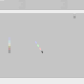

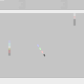

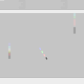

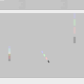

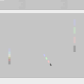

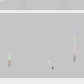

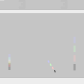

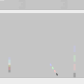

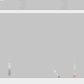

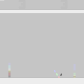

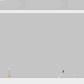

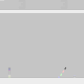

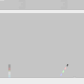

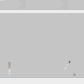

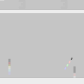

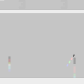

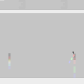

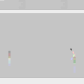

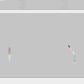

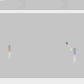

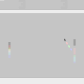

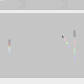

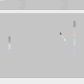

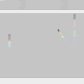

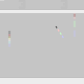

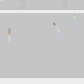

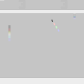

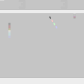

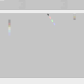

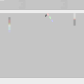

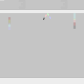

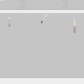

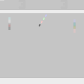

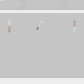

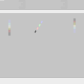

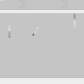

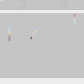

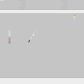

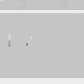

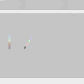

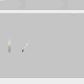

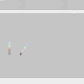

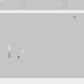

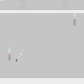

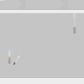

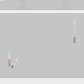

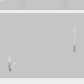

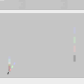

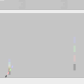

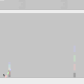

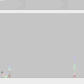

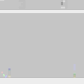

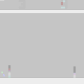

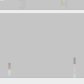

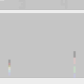

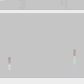

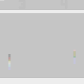

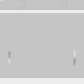

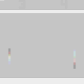

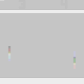

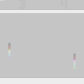

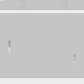

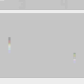

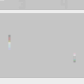

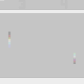

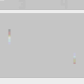

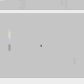

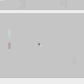

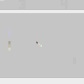

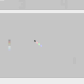

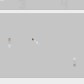

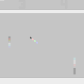

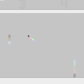

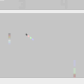

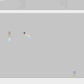

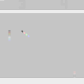

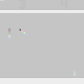

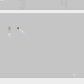

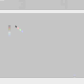

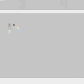

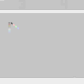

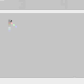

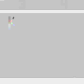

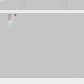

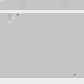

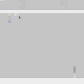

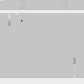

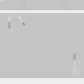

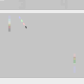

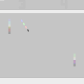

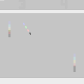

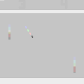

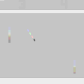

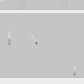

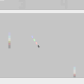

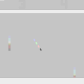

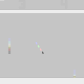

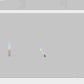

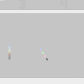

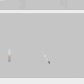

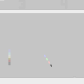

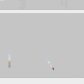

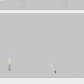

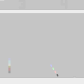

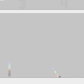

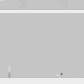

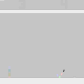

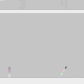

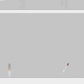

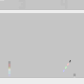

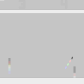

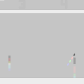

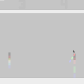

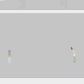

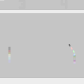

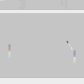

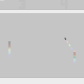

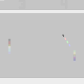

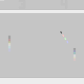

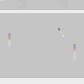

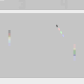

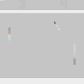

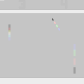

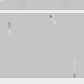

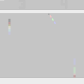

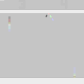

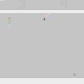

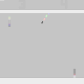

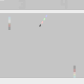

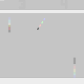

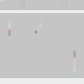

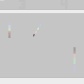

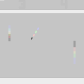

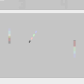

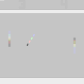

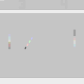

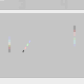

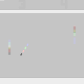

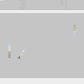

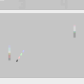

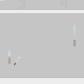

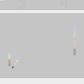

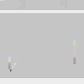

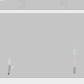

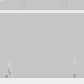

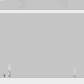

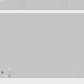

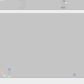

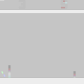

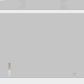

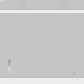

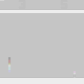

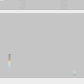

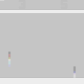

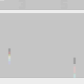

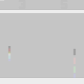

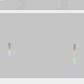

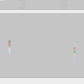

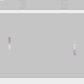

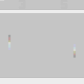

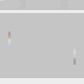

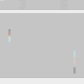

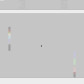

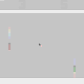

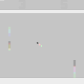

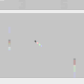

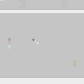

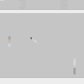

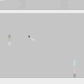

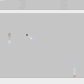

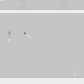

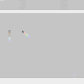

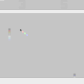

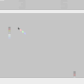

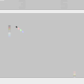

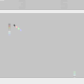

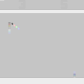

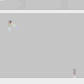

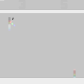

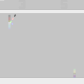

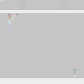

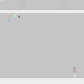

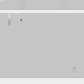

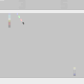

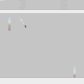

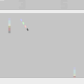

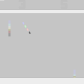

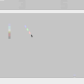

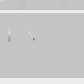

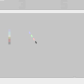

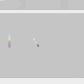

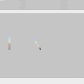

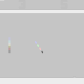

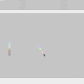

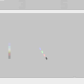

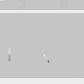

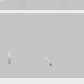

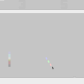

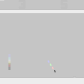

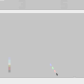

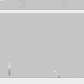

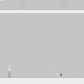

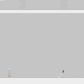

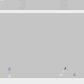

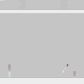

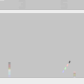

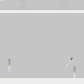

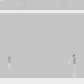

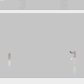

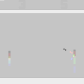

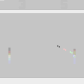

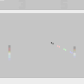

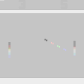

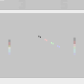

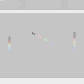

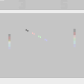

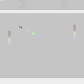

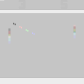

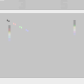

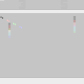

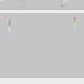

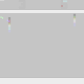

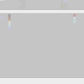

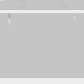

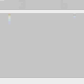

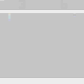

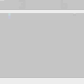

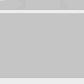

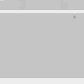

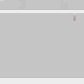

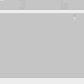

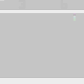

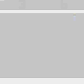

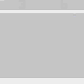

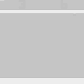

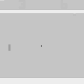

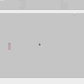

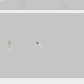

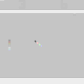

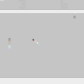

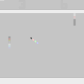

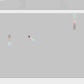

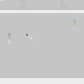

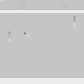

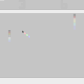

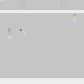

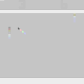

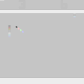

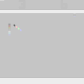

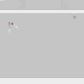

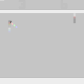

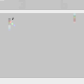

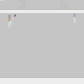

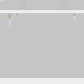

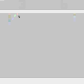

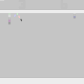

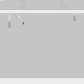

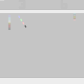

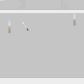

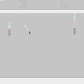

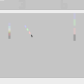

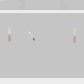

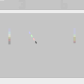

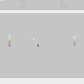

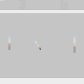

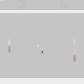

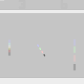

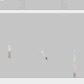

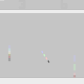

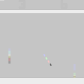

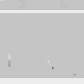

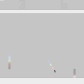

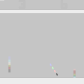

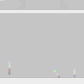

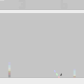

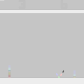

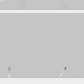

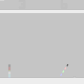

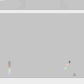

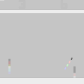

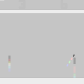

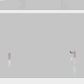

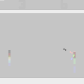

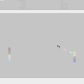

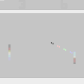

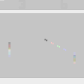

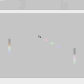

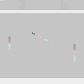

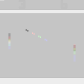

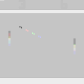

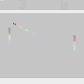

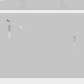

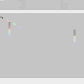

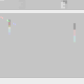

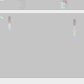

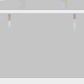

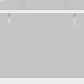

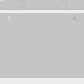

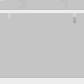

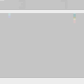

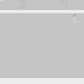

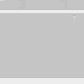

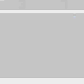

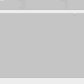

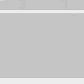

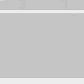

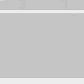

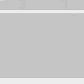

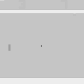

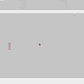

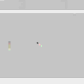

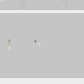

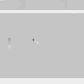

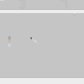

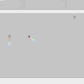

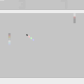

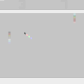

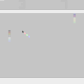

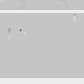

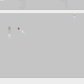

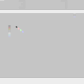

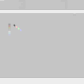

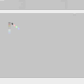

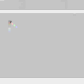

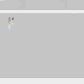

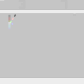

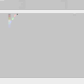

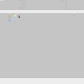

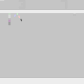

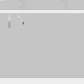

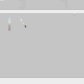

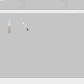

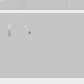

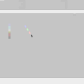

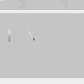

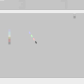

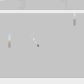

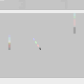

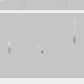

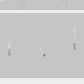

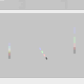

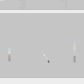

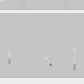

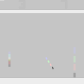

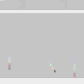

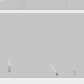

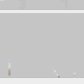

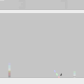

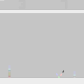

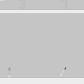

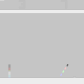

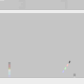

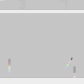

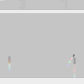

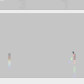

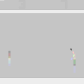

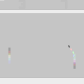

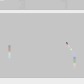

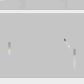

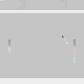

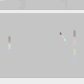

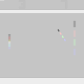

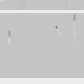

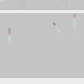

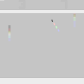

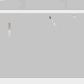

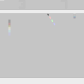

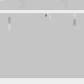

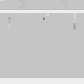

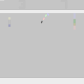

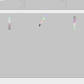

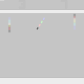

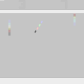

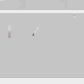

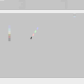

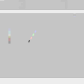

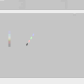

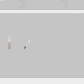

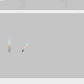

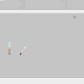

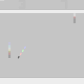

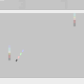

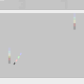

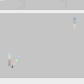

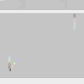

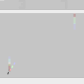

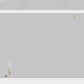

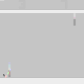

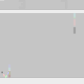

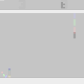

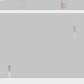

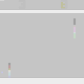

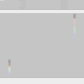

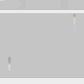

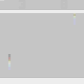

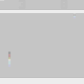

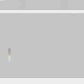

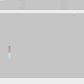

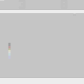

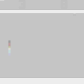

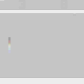

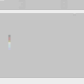

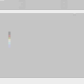

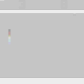

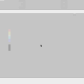

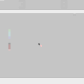

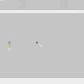

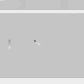

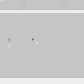

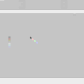

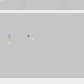

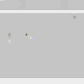

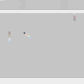

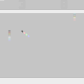

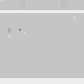

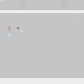

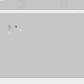

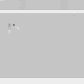

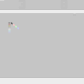

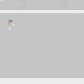

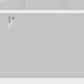

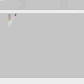

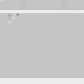

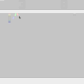

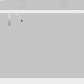

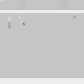

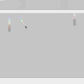

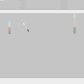

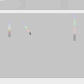

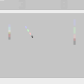

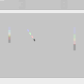

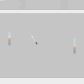

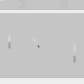

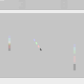

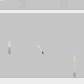

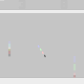

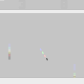

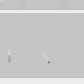

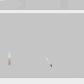

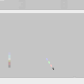

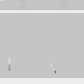

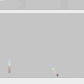

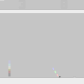

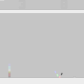

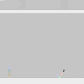

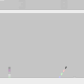

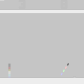

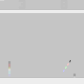

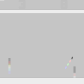

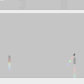

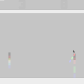

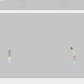

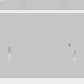

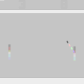

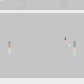

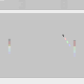

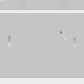

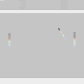

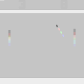

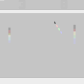

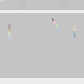

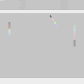

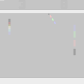

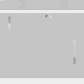

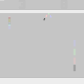

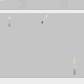

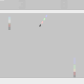

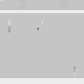

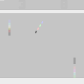

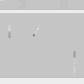

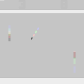

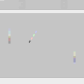

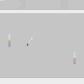

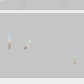

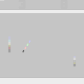

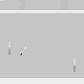

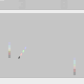

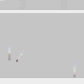

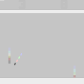

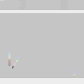

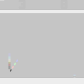

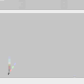

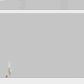

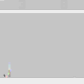

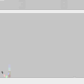

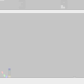

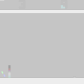

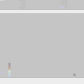

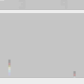

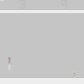

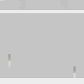

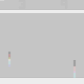

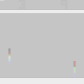

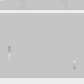

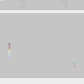

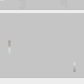

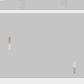

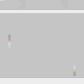

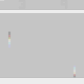

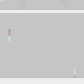

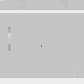

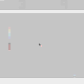

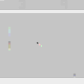

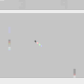

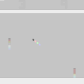

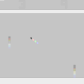

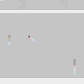

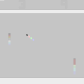

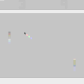

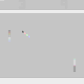

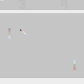

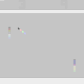

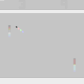

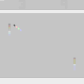

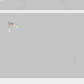

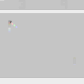

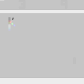

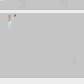

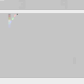

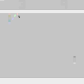

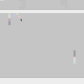

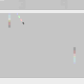

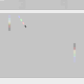

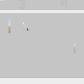

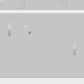

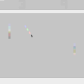

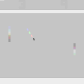

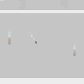

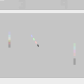

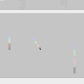

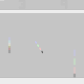

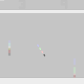

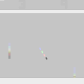

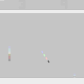

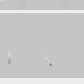

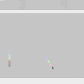

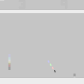

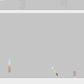

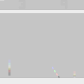

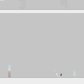

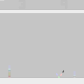

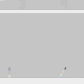

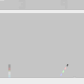

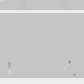

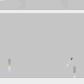

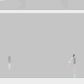

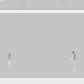

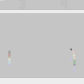

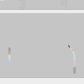

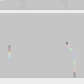

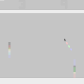

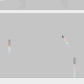

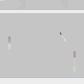

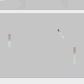

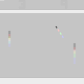

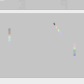

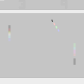

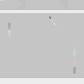

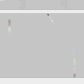

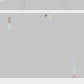

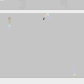

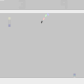

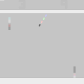

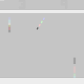

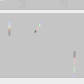

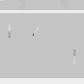

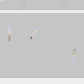

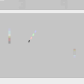

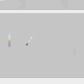

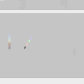

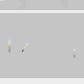

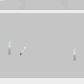

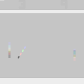

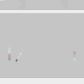

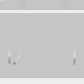

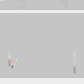

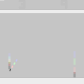

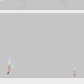

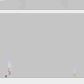

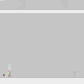

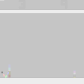

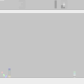

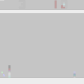

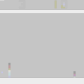

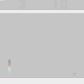

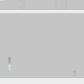

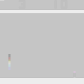

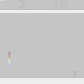

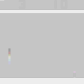

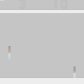

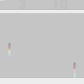

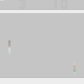

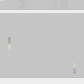

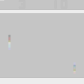

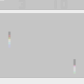

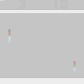

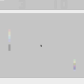

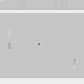

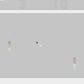

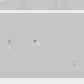

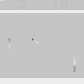

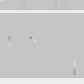

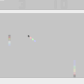

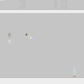

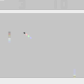

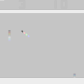

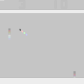

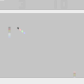

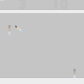

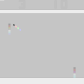

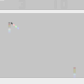

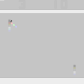

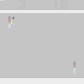

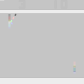

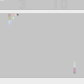

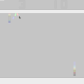

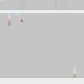

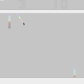

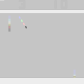

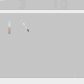

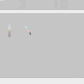

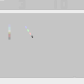

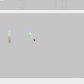

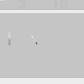

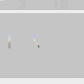

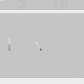

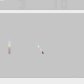

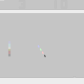

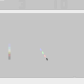

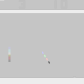

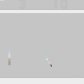

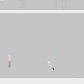

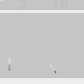

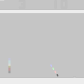

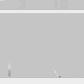

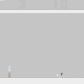

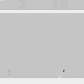

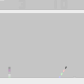

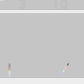

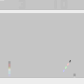

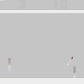

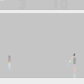

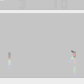

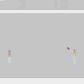

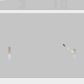

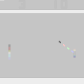

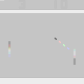

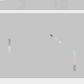

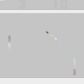

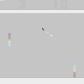

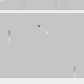

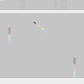

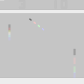

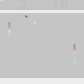

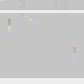

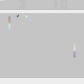

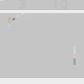

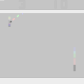

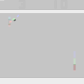

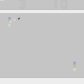

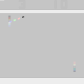

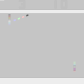

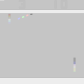

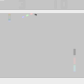

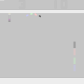

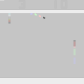

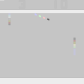

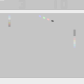

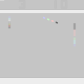

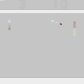

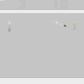

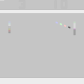

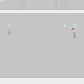

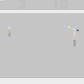

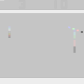

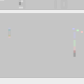

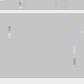

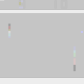

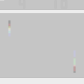

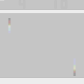

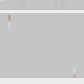

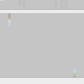

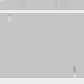

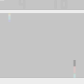

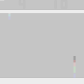

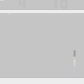

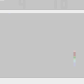

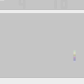

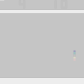

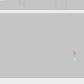

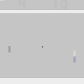

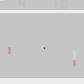

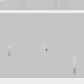

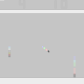

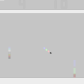

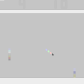

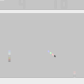

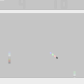

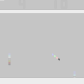

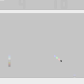

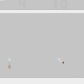

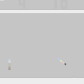

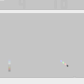

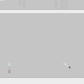

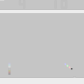

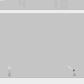

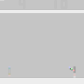

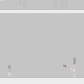

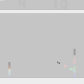

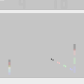

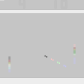

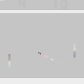

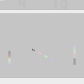

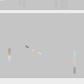

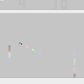

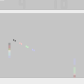

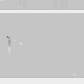

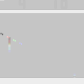

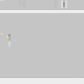

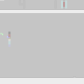

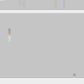

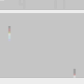

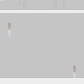

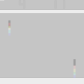

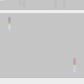

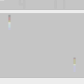

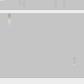

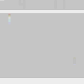

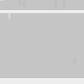

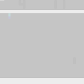

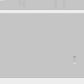

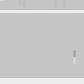

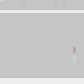

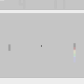

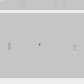

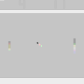

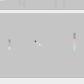

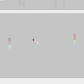

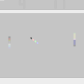

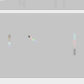

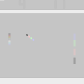

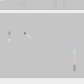

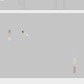

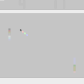

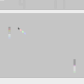

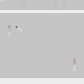

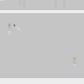

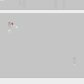

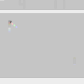

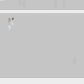

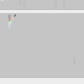

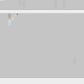

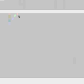

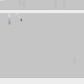

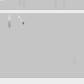

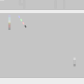

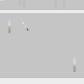

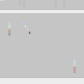

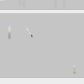

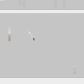

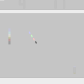

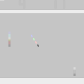

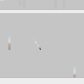

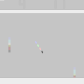

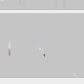

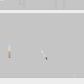

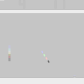

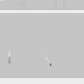

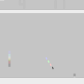

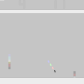

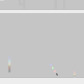

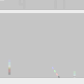

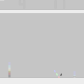

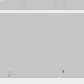

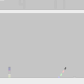

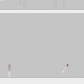

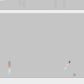

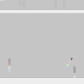

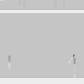

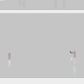

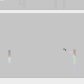

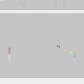

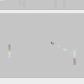

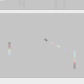

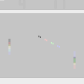

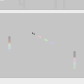

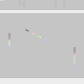

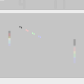

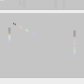

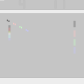

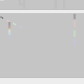

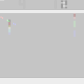

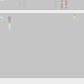

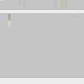

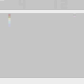

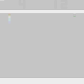

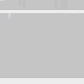

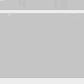

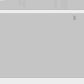

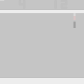

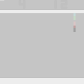

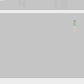

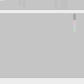

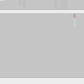

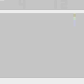

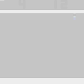

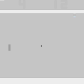

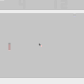

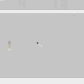

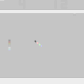

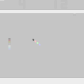

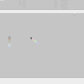

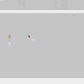

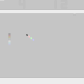

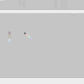

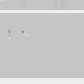

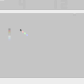

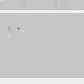

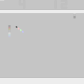

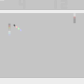

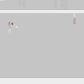

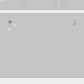

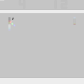

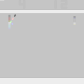

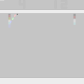

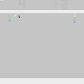

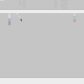

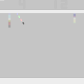

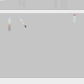

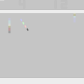

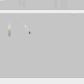

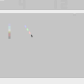

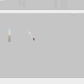

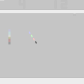

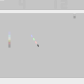

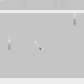

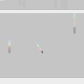

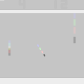

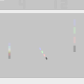

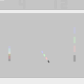

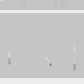

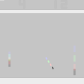

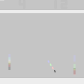

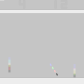

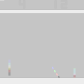

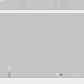

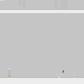

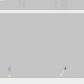

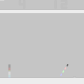

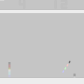

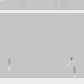

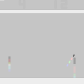

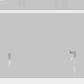

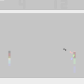

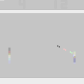

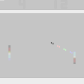

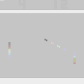

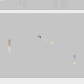

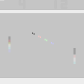

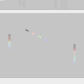

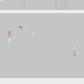

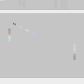

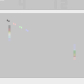

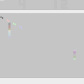

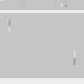

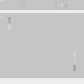

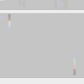

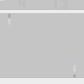

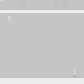

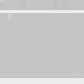

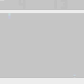

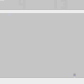

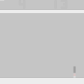

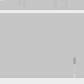

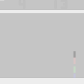

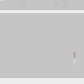

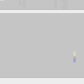

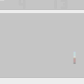

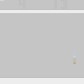

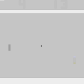

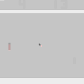

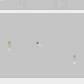

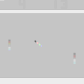

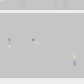

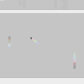

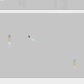

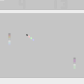

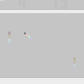

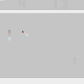

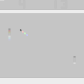

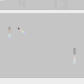

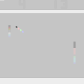

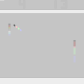

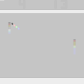

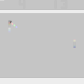

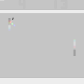

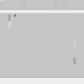

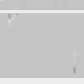

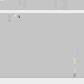

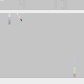

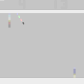

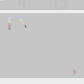

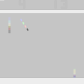

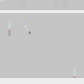

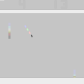

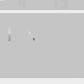

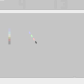

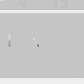

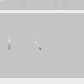

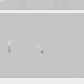

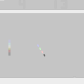

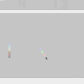

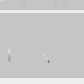

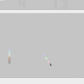

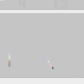

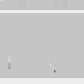

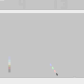

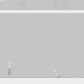

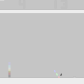

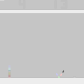

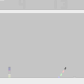

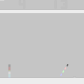

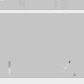

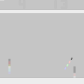

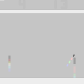

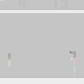

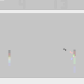

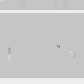

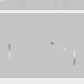

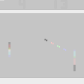

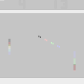

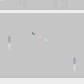

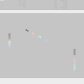

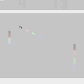

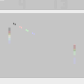

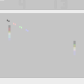

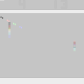

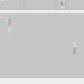

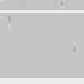

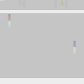

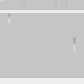

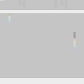

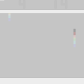

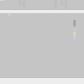

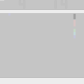

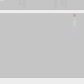

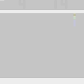

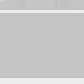

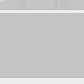

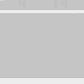

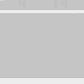

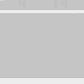

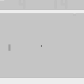

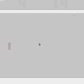

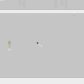

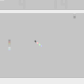

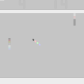

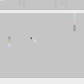

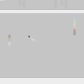

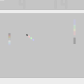

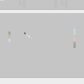

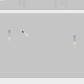

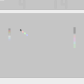

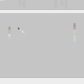

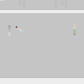

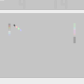

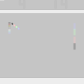

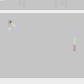

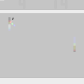

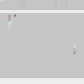

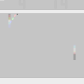

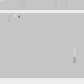

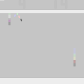

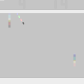

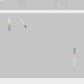

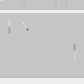

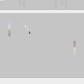

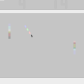

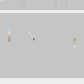

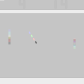

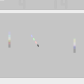

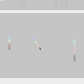

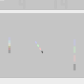

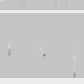

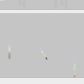

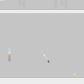

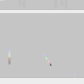

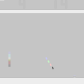

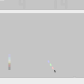

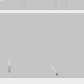

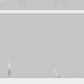

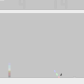

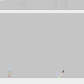

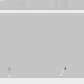

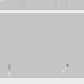

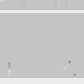

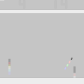

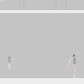

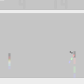

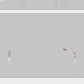

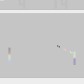

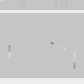

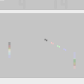

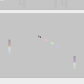

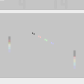

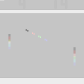

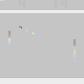

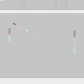

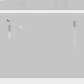

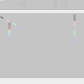

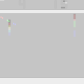

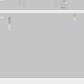

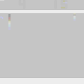

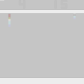

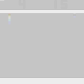

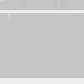

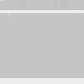

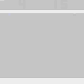

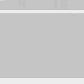

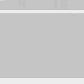

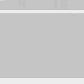

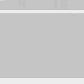

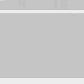

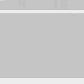

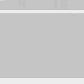

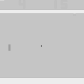

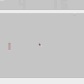

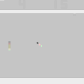

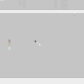

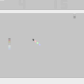

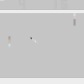

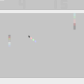

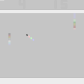

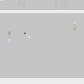

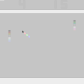

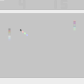

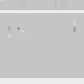

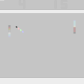

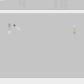

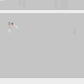

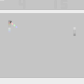

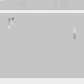

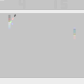

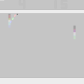

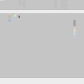

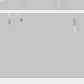

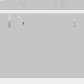

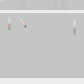

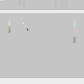

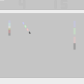

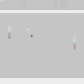

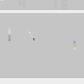

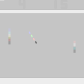

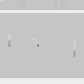

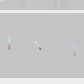

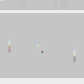

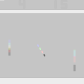

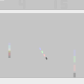

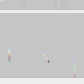

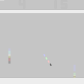

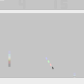

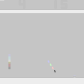

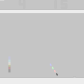

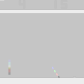

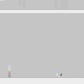

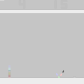

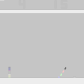

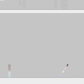

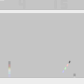

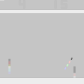

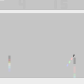

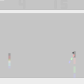

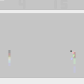

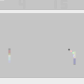

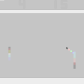

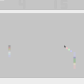

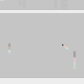

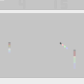

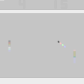

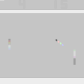

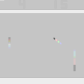

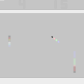

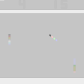

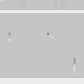

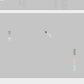

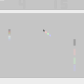

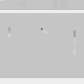

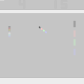

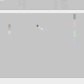

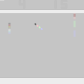

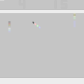

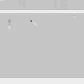

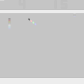

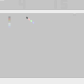

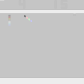

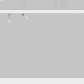

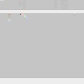

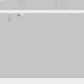

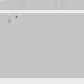

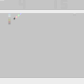

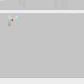

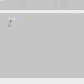

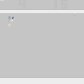

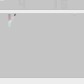

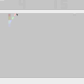

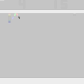

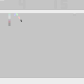

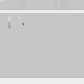

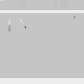

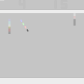

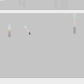

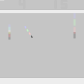

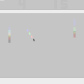

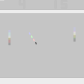

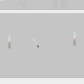

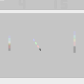

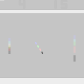

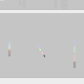

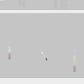

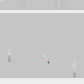

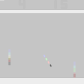

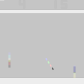

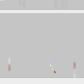

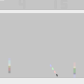

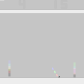

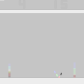

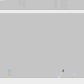

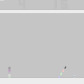

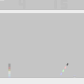

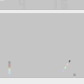

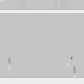

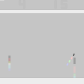

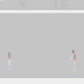

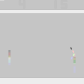

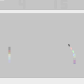

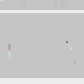

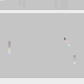

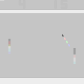

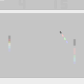

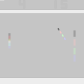

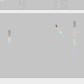

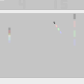

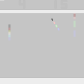

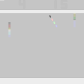

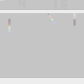

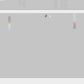

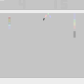

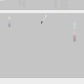

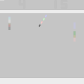

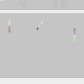

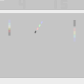

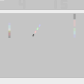

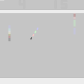

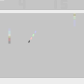

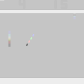

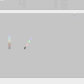

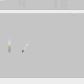

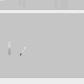

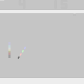

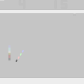

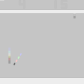

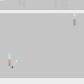

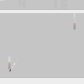

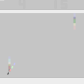

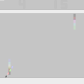

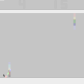

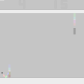

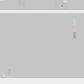

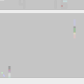

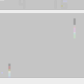

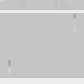

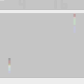

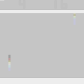

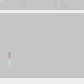

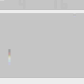

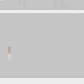

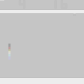

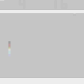

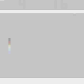

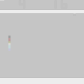

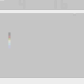

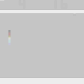

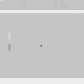

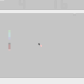

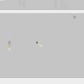

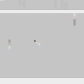

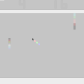

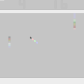

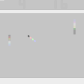

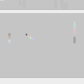

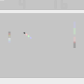

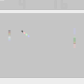

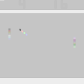

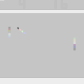

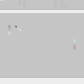

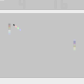

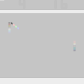

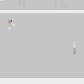

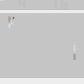

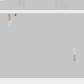

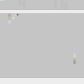

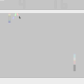

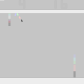

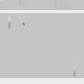

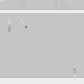

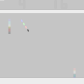

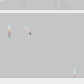

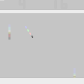

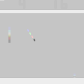

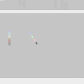

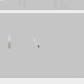

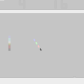

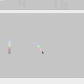

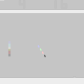

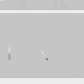

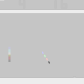

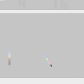

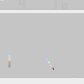

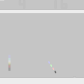

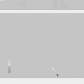

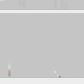

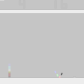

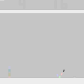

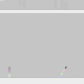

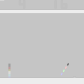

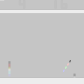

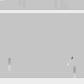

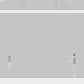

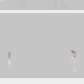

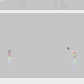

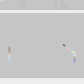

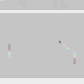

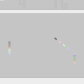

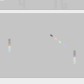

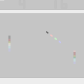

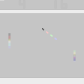

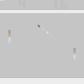

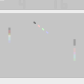

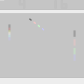

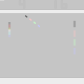

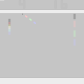

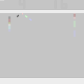

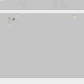

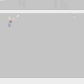

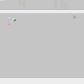

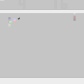

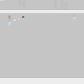

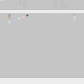

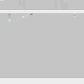

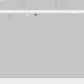

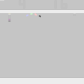

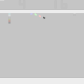

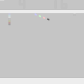

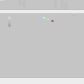

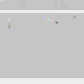

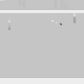

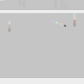

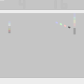

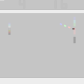

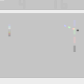

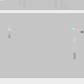

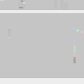

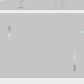

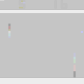

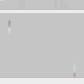

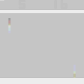

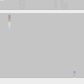

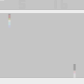

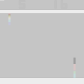

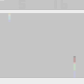

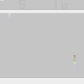

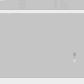

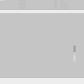

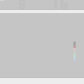

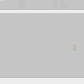

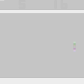

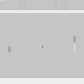

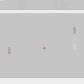

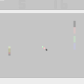

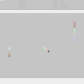

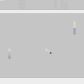

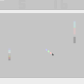

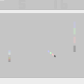

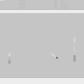

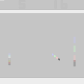

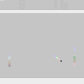

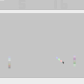

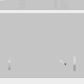

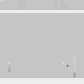

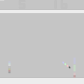

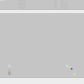

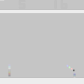

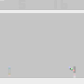

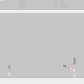

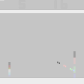

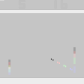

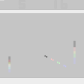

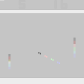

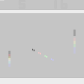

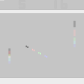

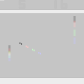

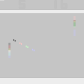

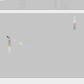

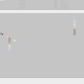

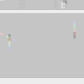

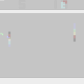

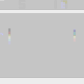

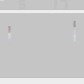

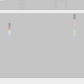

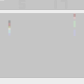

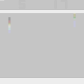

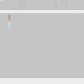

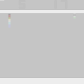

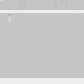

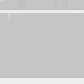

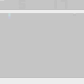

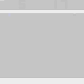

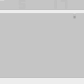

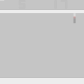

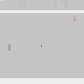

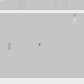

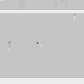

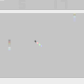

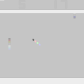

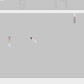

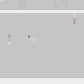

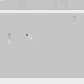

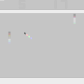

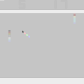

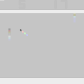

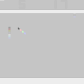

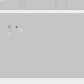

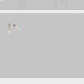

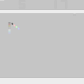

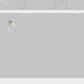

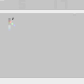

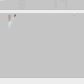

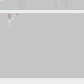

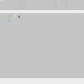

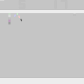

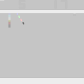

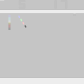

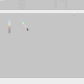

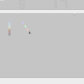

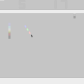

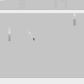

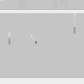

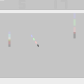

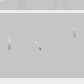

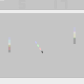

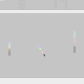

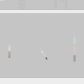

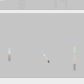

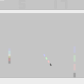

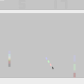

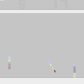

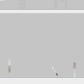

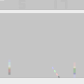

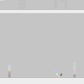

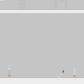

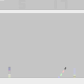

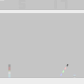

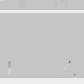

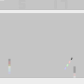

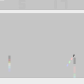

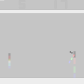

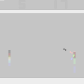

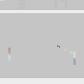

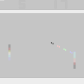

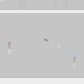

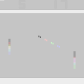

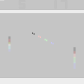

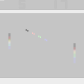

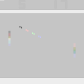

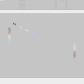

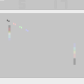

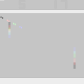

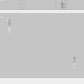

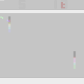

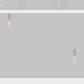

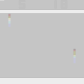

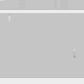

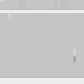

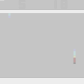

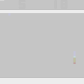

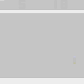

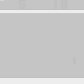

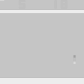

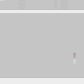

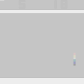

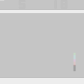

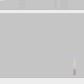

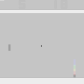

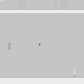

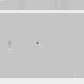

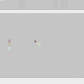

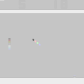

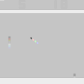

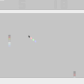

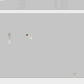

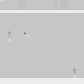

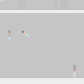

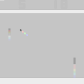

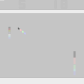

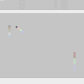

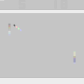

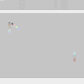

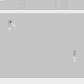

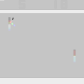

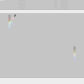

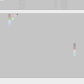

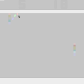

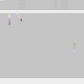

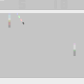

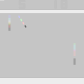

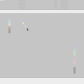

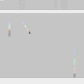

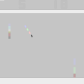

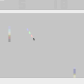

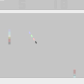

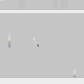

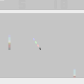

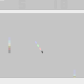

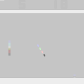

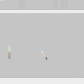

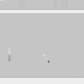

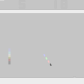

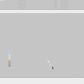

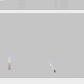

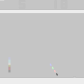

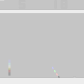

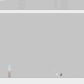

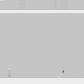

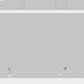

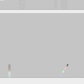

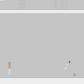

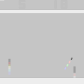

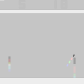

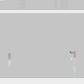

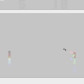

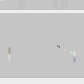

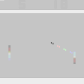

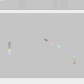

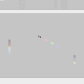

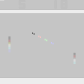

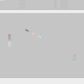

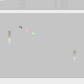

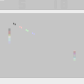

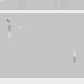

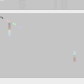

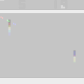

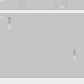

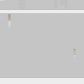

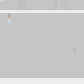

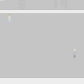

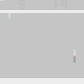

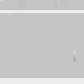

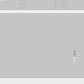

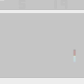

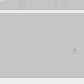

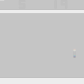

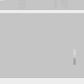

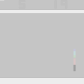

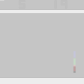

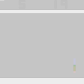

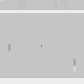

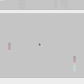

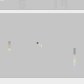

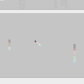

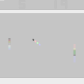

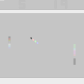

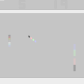

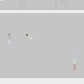

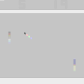

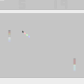

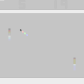

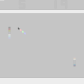

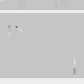

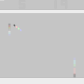

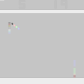

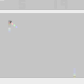

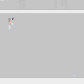

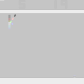

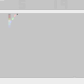

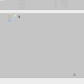

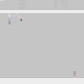

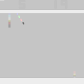

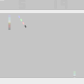

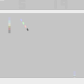

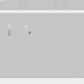

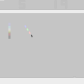

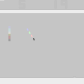

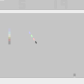

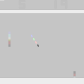

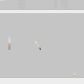

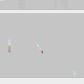

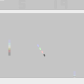

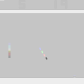

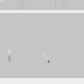

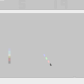

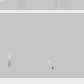

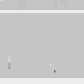

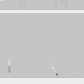

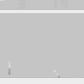

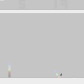

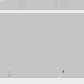

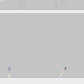

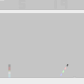

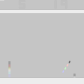

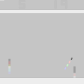

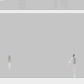

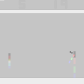

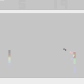

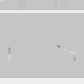

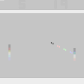

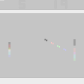

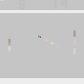

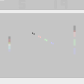

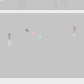

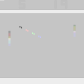

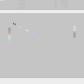

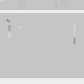

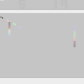

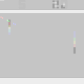

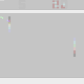

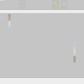

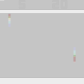

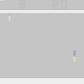

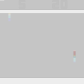

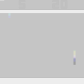

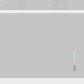

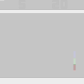

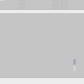

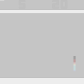

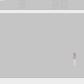

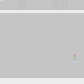

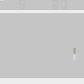

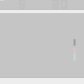

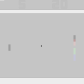

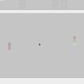

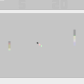

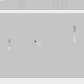

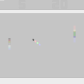

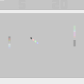

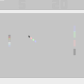

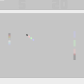

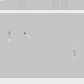

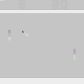

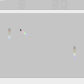

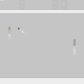

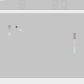

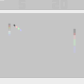

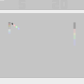

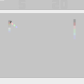

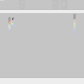

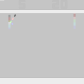

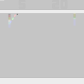

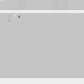

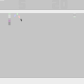

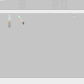

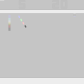

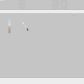

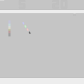

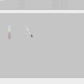

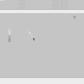

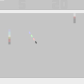

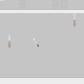

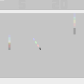

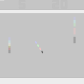

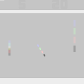

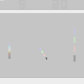

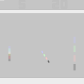

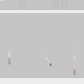

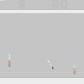

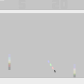

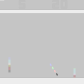

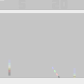

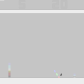

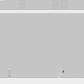

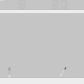

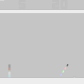

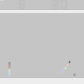

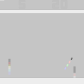

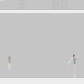

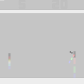

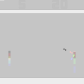

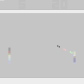

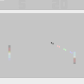

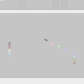

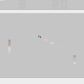

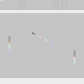

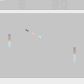

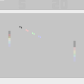

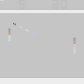

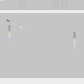

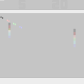

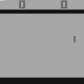

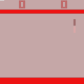

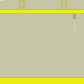

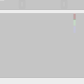

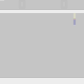

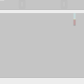

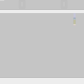

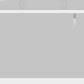

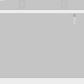

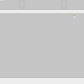

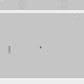

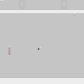

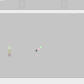

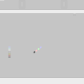

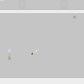

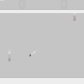

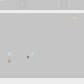

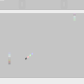

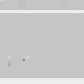

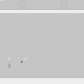

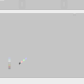

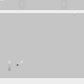

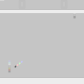

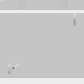

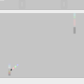

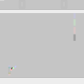

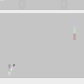

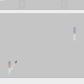

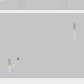

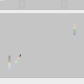

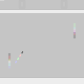

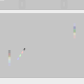

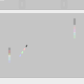

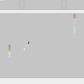

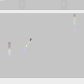

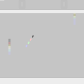

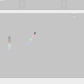

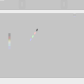

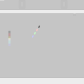

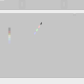

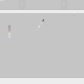

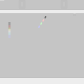

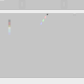

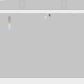

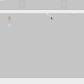

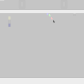

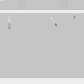

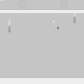

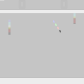

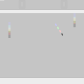

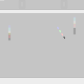

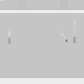

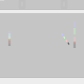

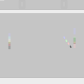

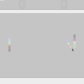

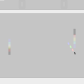

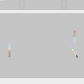

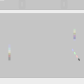

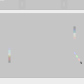

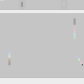

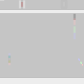

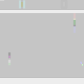

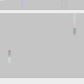

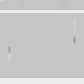

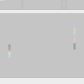

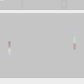

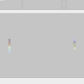

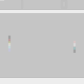

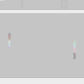

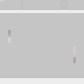

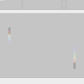

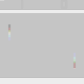

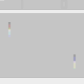

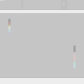

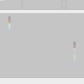

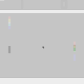

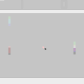

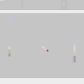

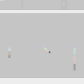

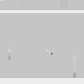

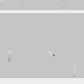

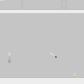

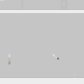

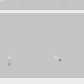

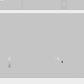

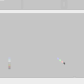

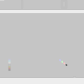

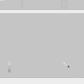

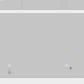

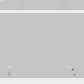

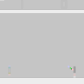

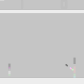

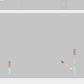

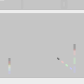

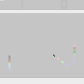

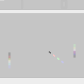

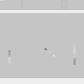

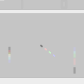

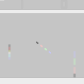

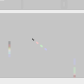

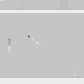

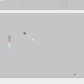

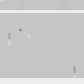

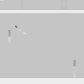

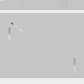

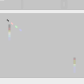

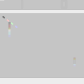

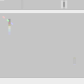

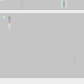

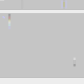

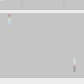

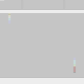

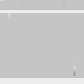

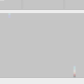

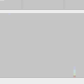

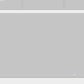

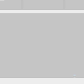

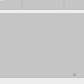

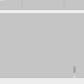

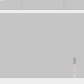

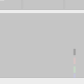

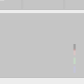

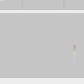

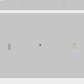

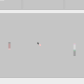

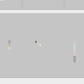

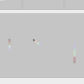

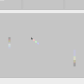

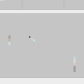

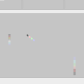

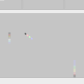

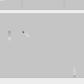

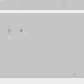

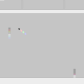

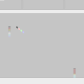

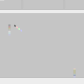

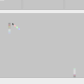

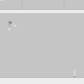

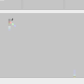

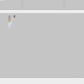

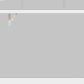

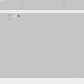

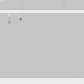

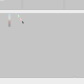

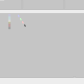

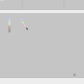

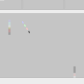

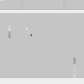

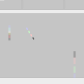

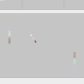

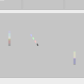

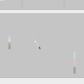

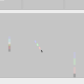

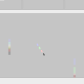

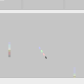

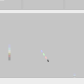

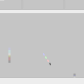

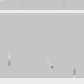

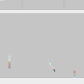

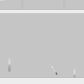

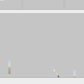

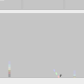

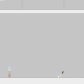

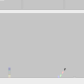

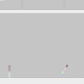

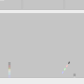

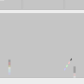

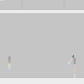

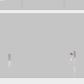

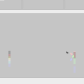

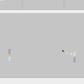

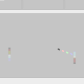

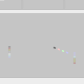

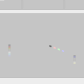

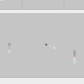

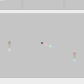

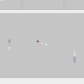

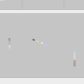

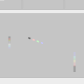

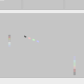

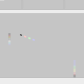

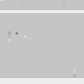

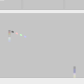

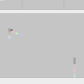

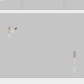

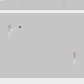

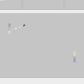

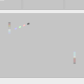

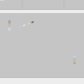

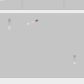

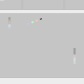

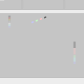

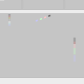

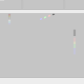

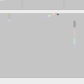

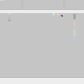

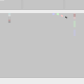

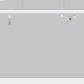

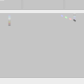

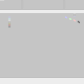

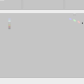

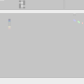

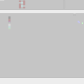

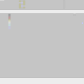

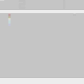

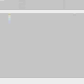

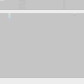

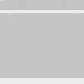

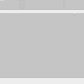

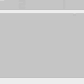

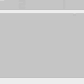

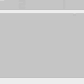

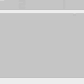

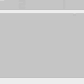

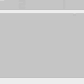

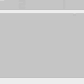

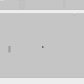

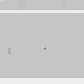

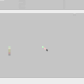

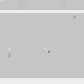

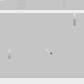

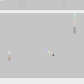

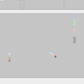

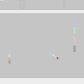

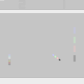

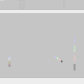

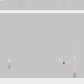

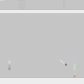

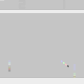

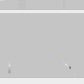

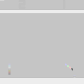

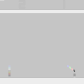

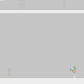

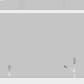

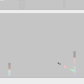

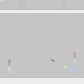

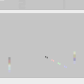

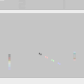

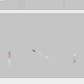

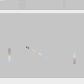

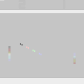

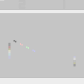

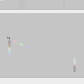

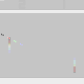

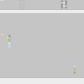

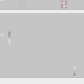

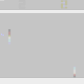

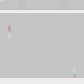

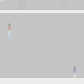

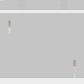

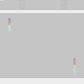

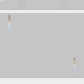

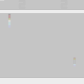

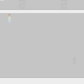

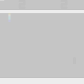

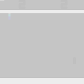

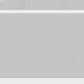

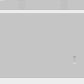

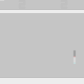

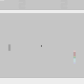

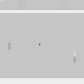

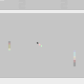

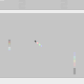

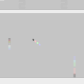

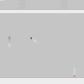

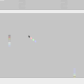

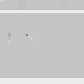

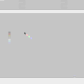

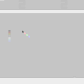

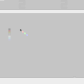

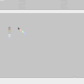

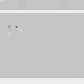

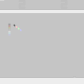

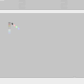

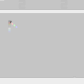

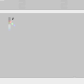

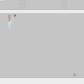

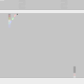

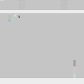

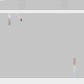

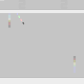

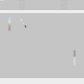

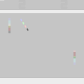

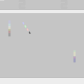

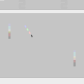

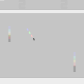

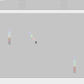

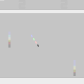

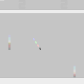

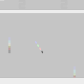

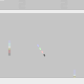

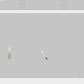

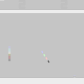

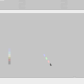

In [13]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from google.colab.patches import cv2_imshow

# Load the saved model
model = PPO.load(os.path.join(MODEL_DIR, "ppo-PongNoFrameskip-v4.zip"))

# Re-create the test environment
test_env = make_atari_env("PongNoFrameskip-v4", n_envs=1, seed=0)
test_env = VecFrameStack(test_env, n_stack=4)

# Run the trained model in inference mode
obs = test_env.reset()
for _ in range(5000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    cv2_imshow(obs[0])
    if dones:
        obs = test_env.reset()

test_env.close()


In [14]:
import base64
from IPython.display import HTML

# Recreate the environment
eval_env = make_atari_env("PongNoFrameskip-v4", n_envs=1, seed=0)
eval_env = VecFrameStack(eval_env, n_stack=4)

# Set the path to save the video
VIDEO_LENGTH = 2000  # number of steps to record
video_path = os.path.join(VIDEO_DIR, "ppo-pong-eval")

# Wrap the environment to record a video
eval_env = VecVideoRecorder(
    eval_env,
    video_folder=VIDEO_DIR,
    record_video_trigger=lambda step: step == 0,
    video_length=VIDEO_LENGTH,
    name_prefix="ppo-pong-eval"
)

# Reset the environment
obs = eval_env.reset()

# Run the agent
for _ in range(VIDEO_LENGTH + 1):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = eval_env.step(action)

# Close the environment and save the video
eval_env.close()


Saving video to /content/drive/MyDrive/Reinforcement_Learning_Projects/PPO_Pong_Agent/videos/ppo-pong-eval-step-0-to-step-2000.mp4


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/drive/MyDrive/Reinforcement_Learning_Projects/PPO_Pong_Agent/videos/ppo-pong-eval-step-0-to-step-2000.mp4.
Moviepy - Writing video /content/drive/MyDrive/Reinforcement_Learning_Projects/PPO_Pong_Agent/videos/ppo-pong-eval-step-0-to-step-2000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Reinforcement_Learning_Projects/PPO_Pong_Agent/videos/ppo-pong-eval-step-0-to-step-2000.mp4


In [18]:
# Function to display video in Colab
def display_video(video_file):
    if not os.path.exists(video_file):
        raise FileNotFoundError(f"Video not found at {video_file}")

    video_b64 = base64.b64encode(open(video_file, "rb").read()).decode()
    return HTML(f"""
    <video width=512 controls>
        <source src="data:video/mp4;base64,{video_b64}" type="video/mp4">
    </video>
    """)

In [19]:
# Display the saved video
display_video(os.path.join(VIDEO_DIR, "ppo-pong-eval-step-0-to-step-2000.mp4"))
